# Safety-Threshold MAGB

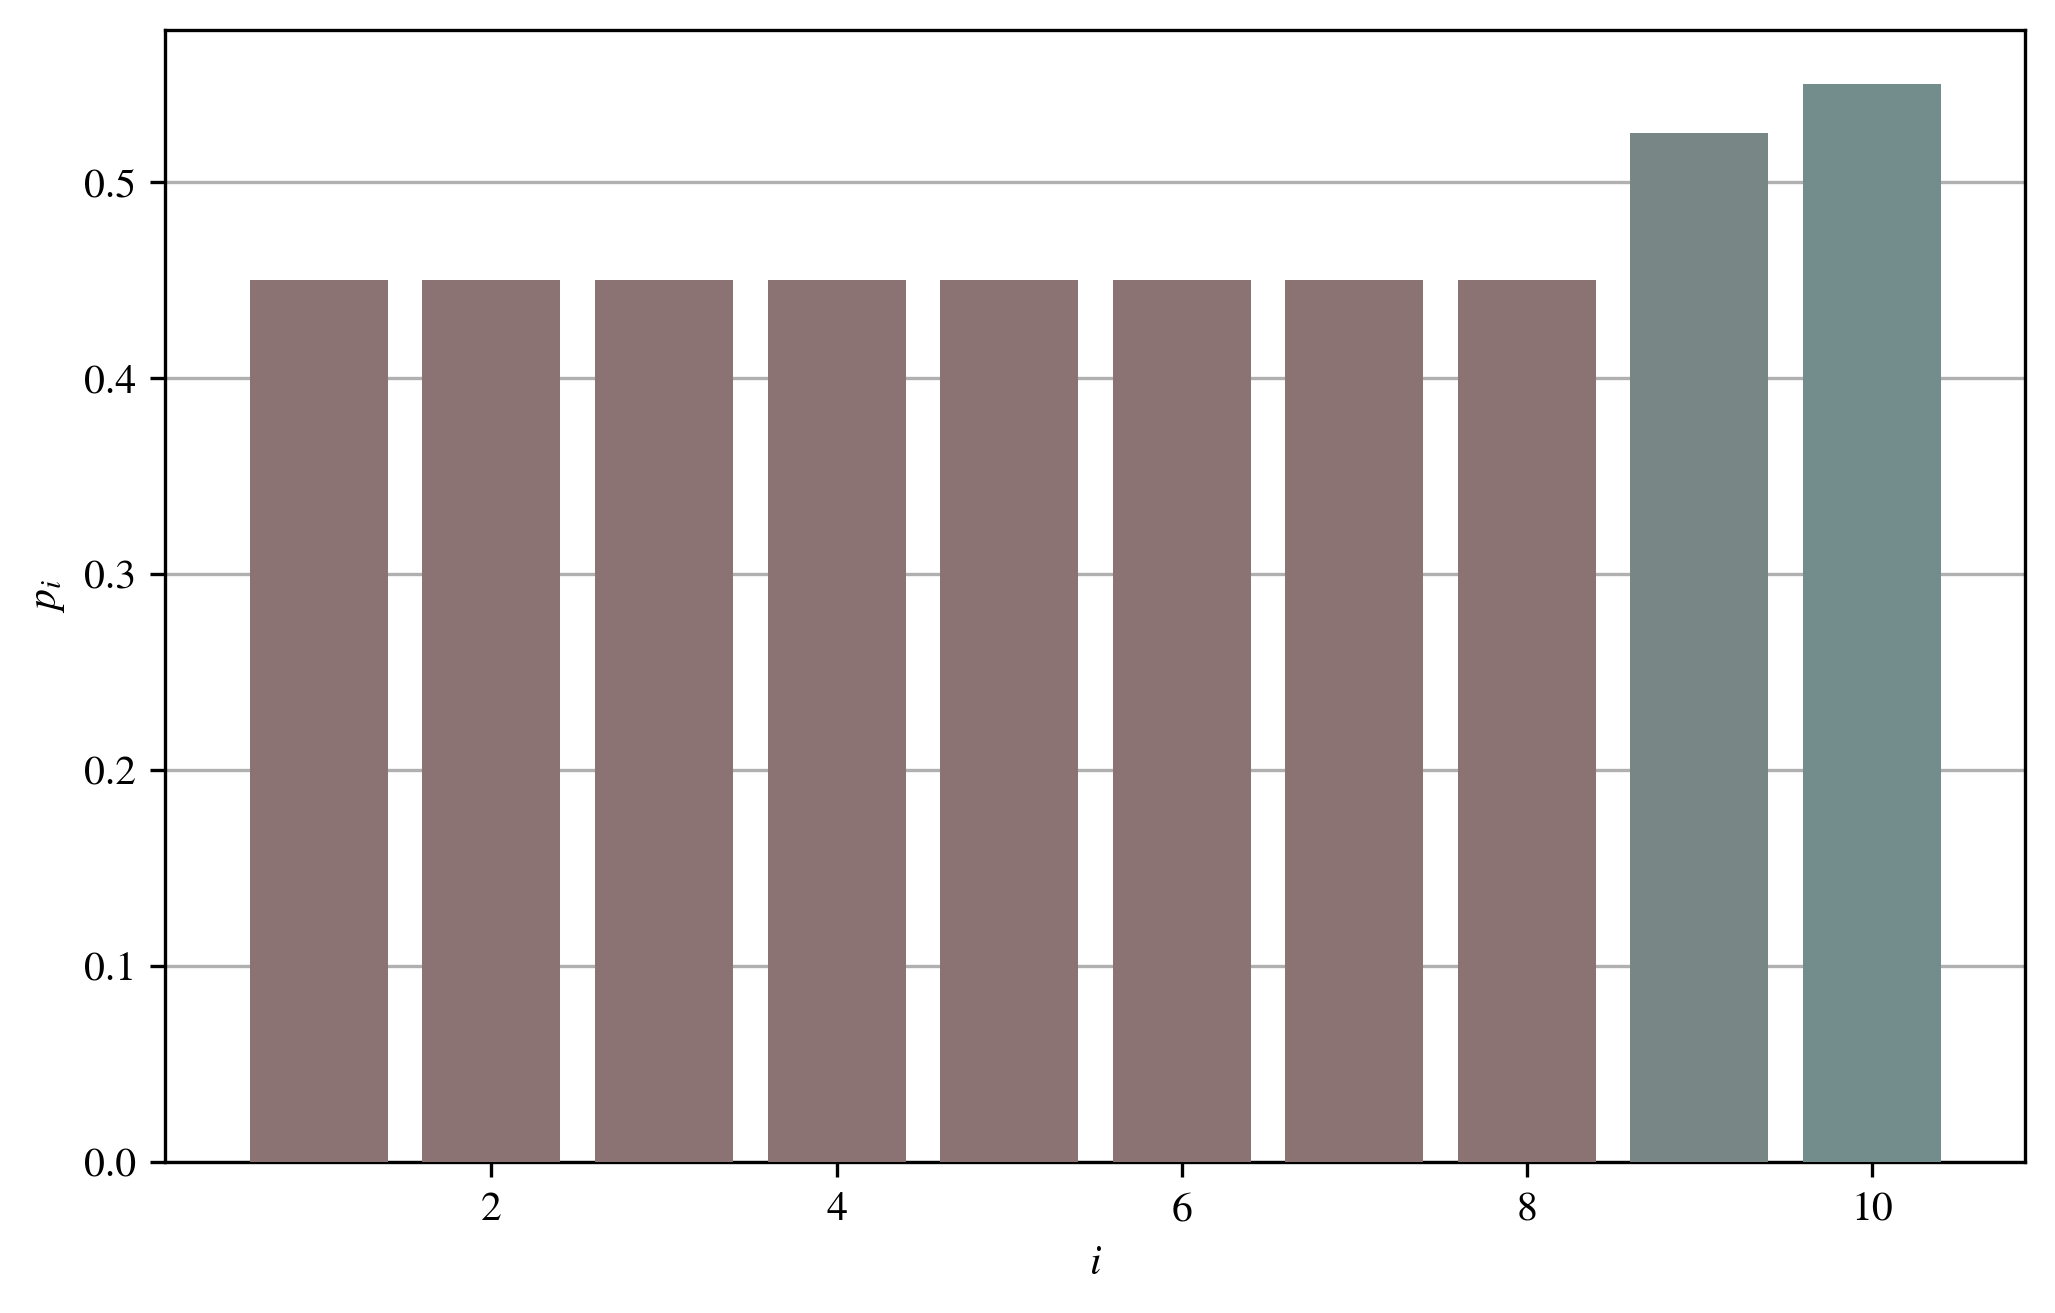

In [1]:
#Import Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from scipy.stats import norm

from datetime import datetime
import pickle

#current date
date = datetime.now().strftime("%Y_%m_%d")

#save pickle
save_pickle = False

#matplolib with latex style
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300

mpl.rcParams["figure.figsize"] = (8,5)

#Configure path for local packages
import setup

from magb.arms import RandomArm, BernoulliArm, GaussianArm, TruncGaussianArm
from magb.policies import FixedPolicy, GreedyPolicy, RandomPolicy, SequentialEpsilonGreedyPolicy, EpsilonGreedyPolicy, EmpiricalSumPolicy
from magb.policies import ExploreThenExploitPolicy, SequentialExploreThenExploitPolicy, SequentialPolicy
from magb.policies import SoftMaxPolicy, UCBPolicy, ThompsonPolicy, BayesUCBPolicy
from magb.simulator import SMAB

#number of arms and corresponding parameters
#k = 10
#p_arr = np.linspace(0.0, 0.6, k)
#p_arr = [0.325, 0.350, 0.375, 0.400, 0.425, 0.450, 0.475, 0.500, 0.525, 0.550]
p_arr = [0.45] * 8 + [0.525, 0.55]
k = len(p_arr)

#Bernoulli
arms = [BernoulliArm(p, minr=-1.0, maxr=+1.0) for p in p_arr]

#initial budget
b_0 = k
omega = k 

#each arm must be tried at least w times at beginning
w=1

fig, ax = plt.subplots(1)
ax.grid(visible=True, which='major', axis='y', zorder=0)
ax.set_xlabel('$i$')
ax.set_ylabel('$p_i$')
for i, p in enumerate(p_arr):
    ax.bar(i+1, p, zorder=3, color=(1-p, p, p, 1.0))
plt.show()


In [2]:
smooth_window = 2*k

#time-horizon
h = 1000

#repetitions
n = 200

#algorithms
algs = [FixedPolicy(k, w=0, fixed_i=i+1) for i in range(k)]
    
sim = SMAB(arms, algs, h, b_0, n=n, use_multiprocess=True, prev_draw=True)

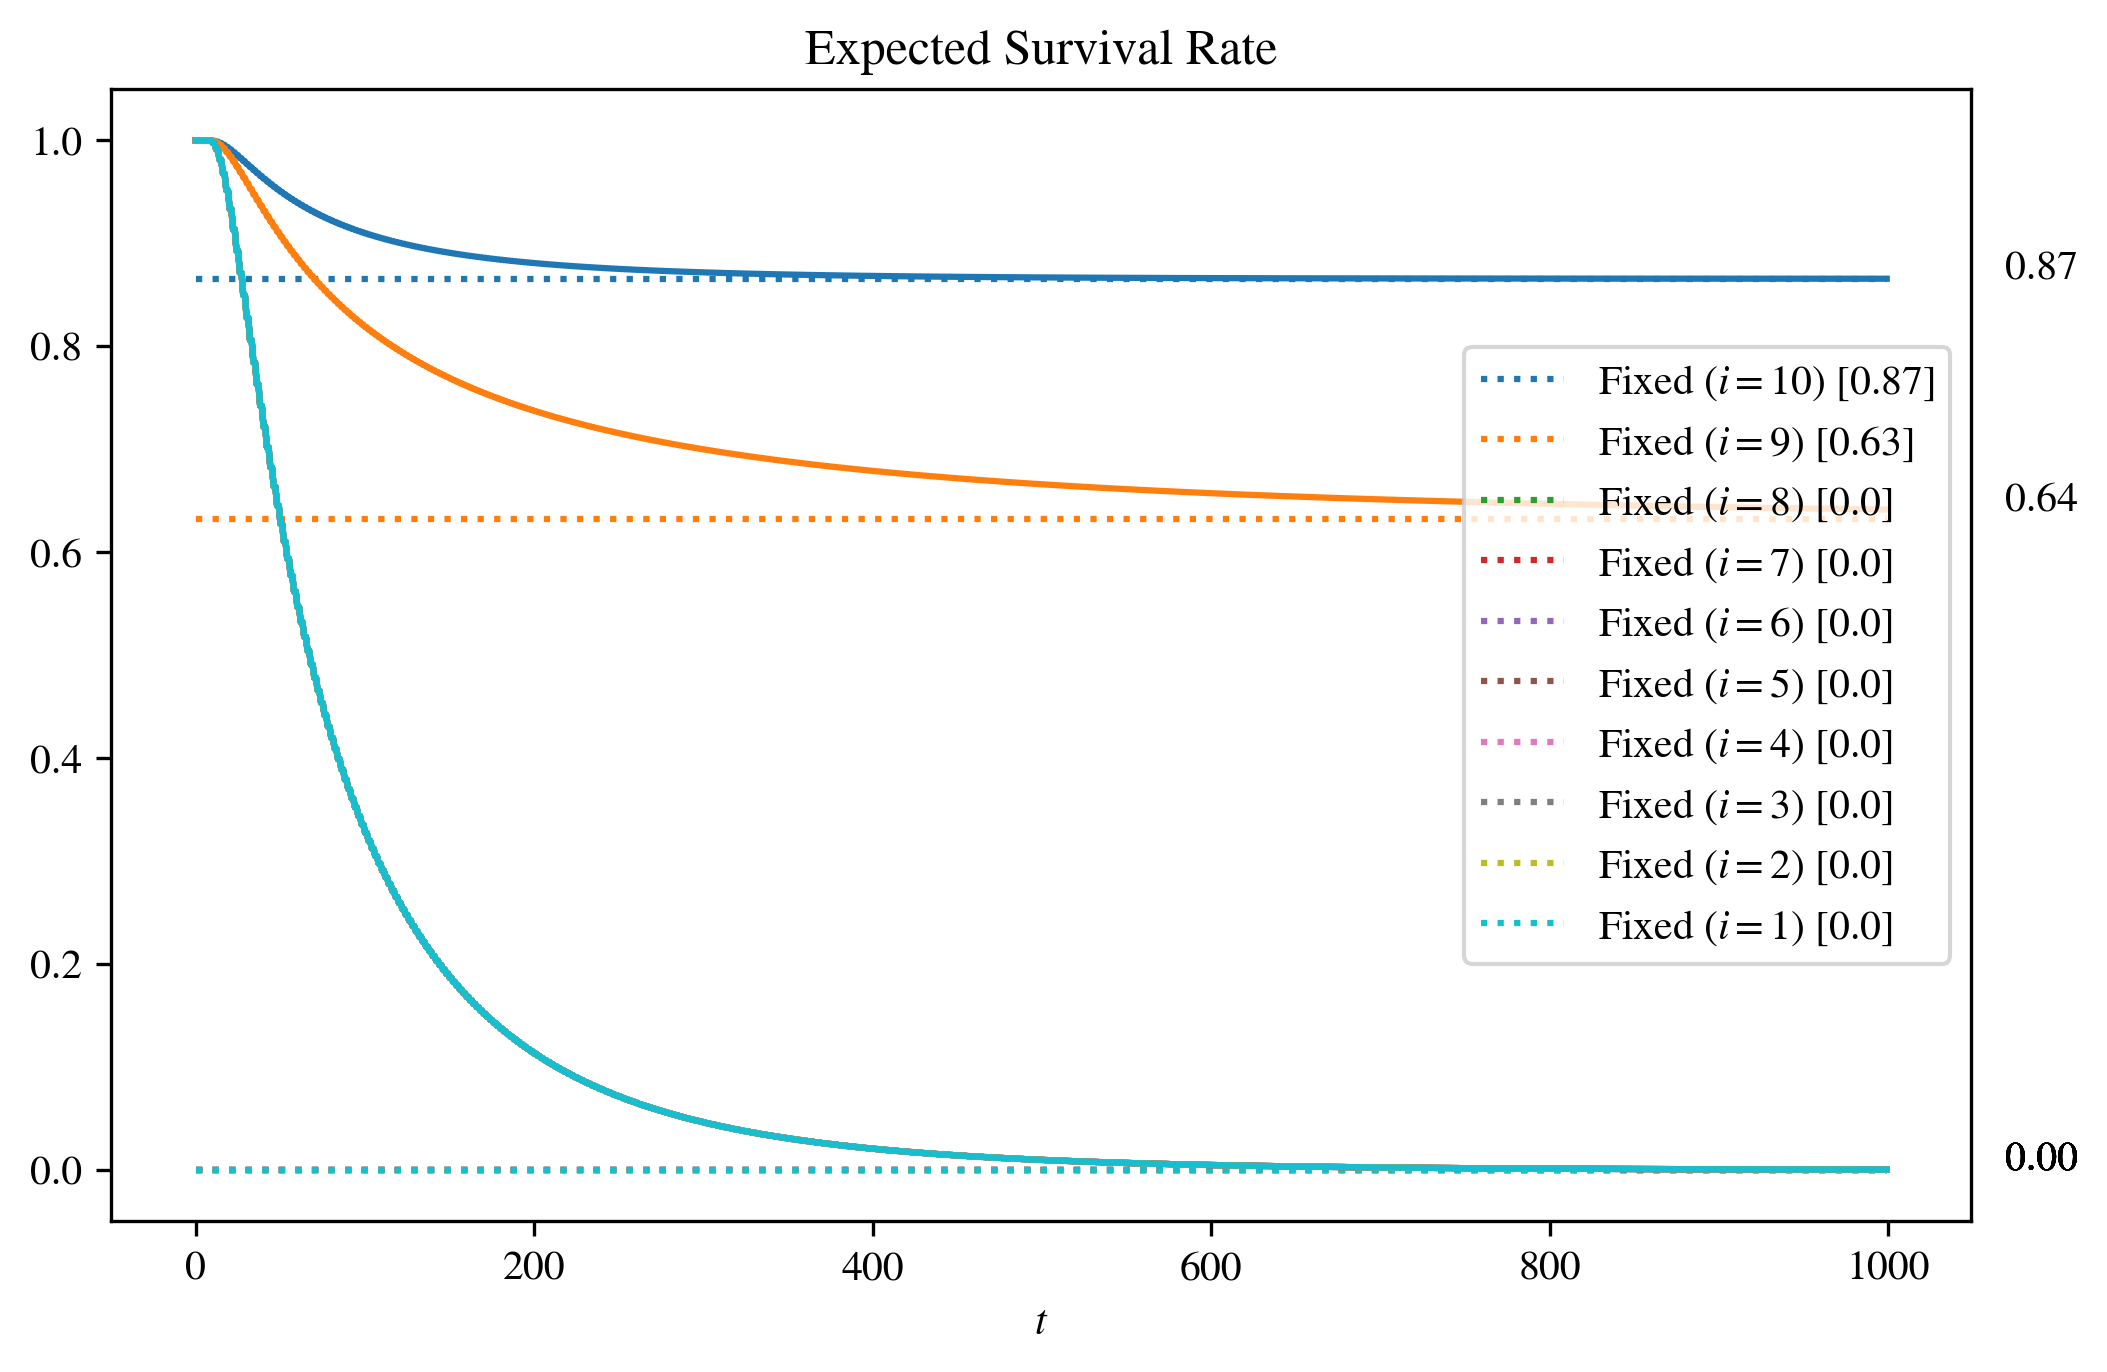

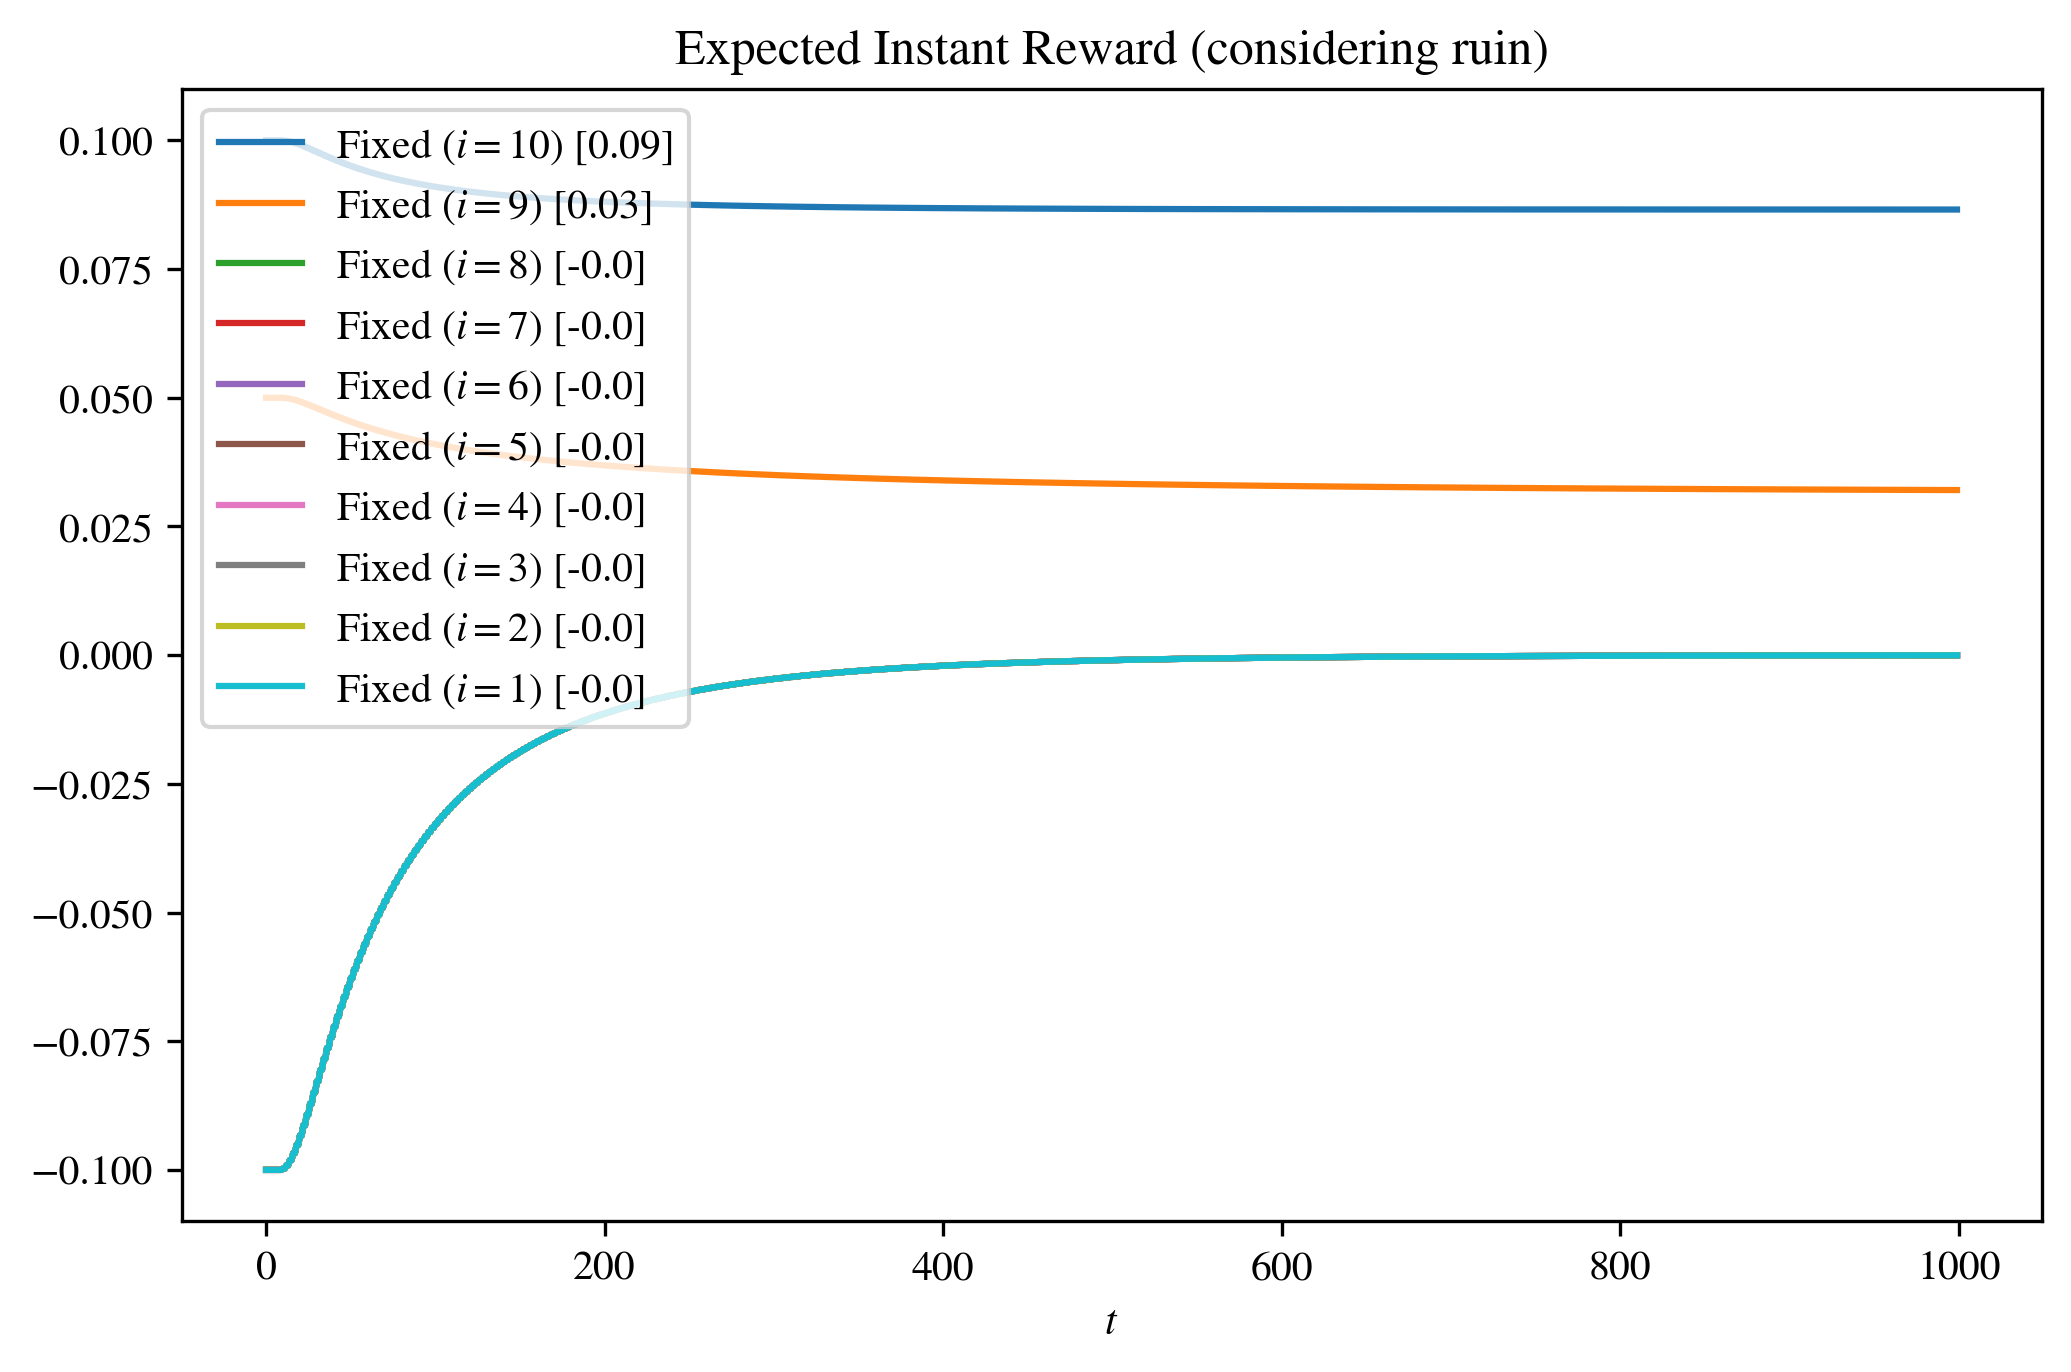

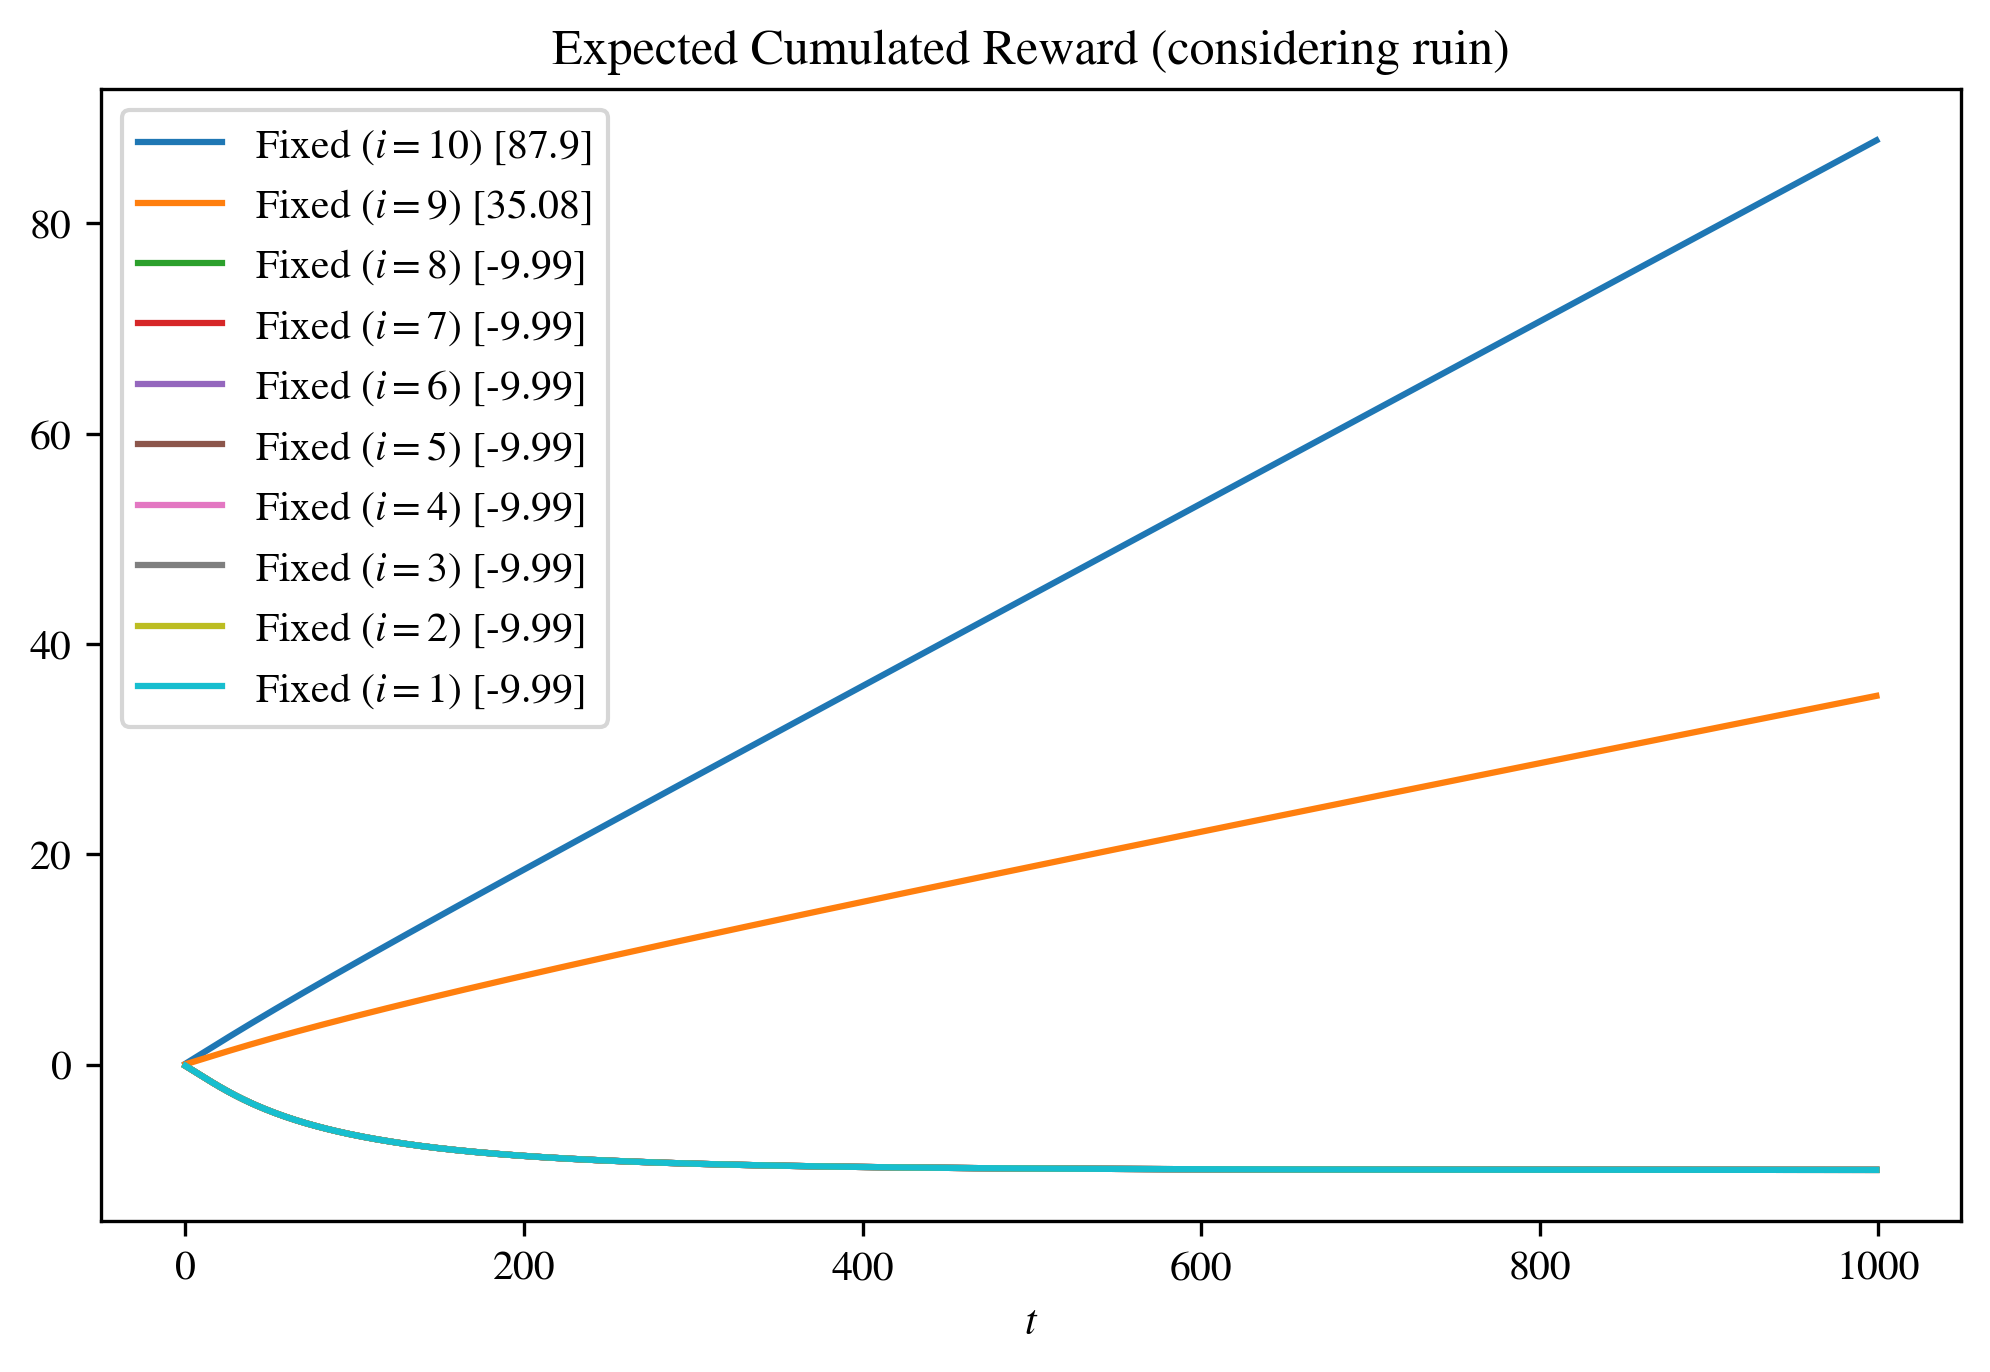

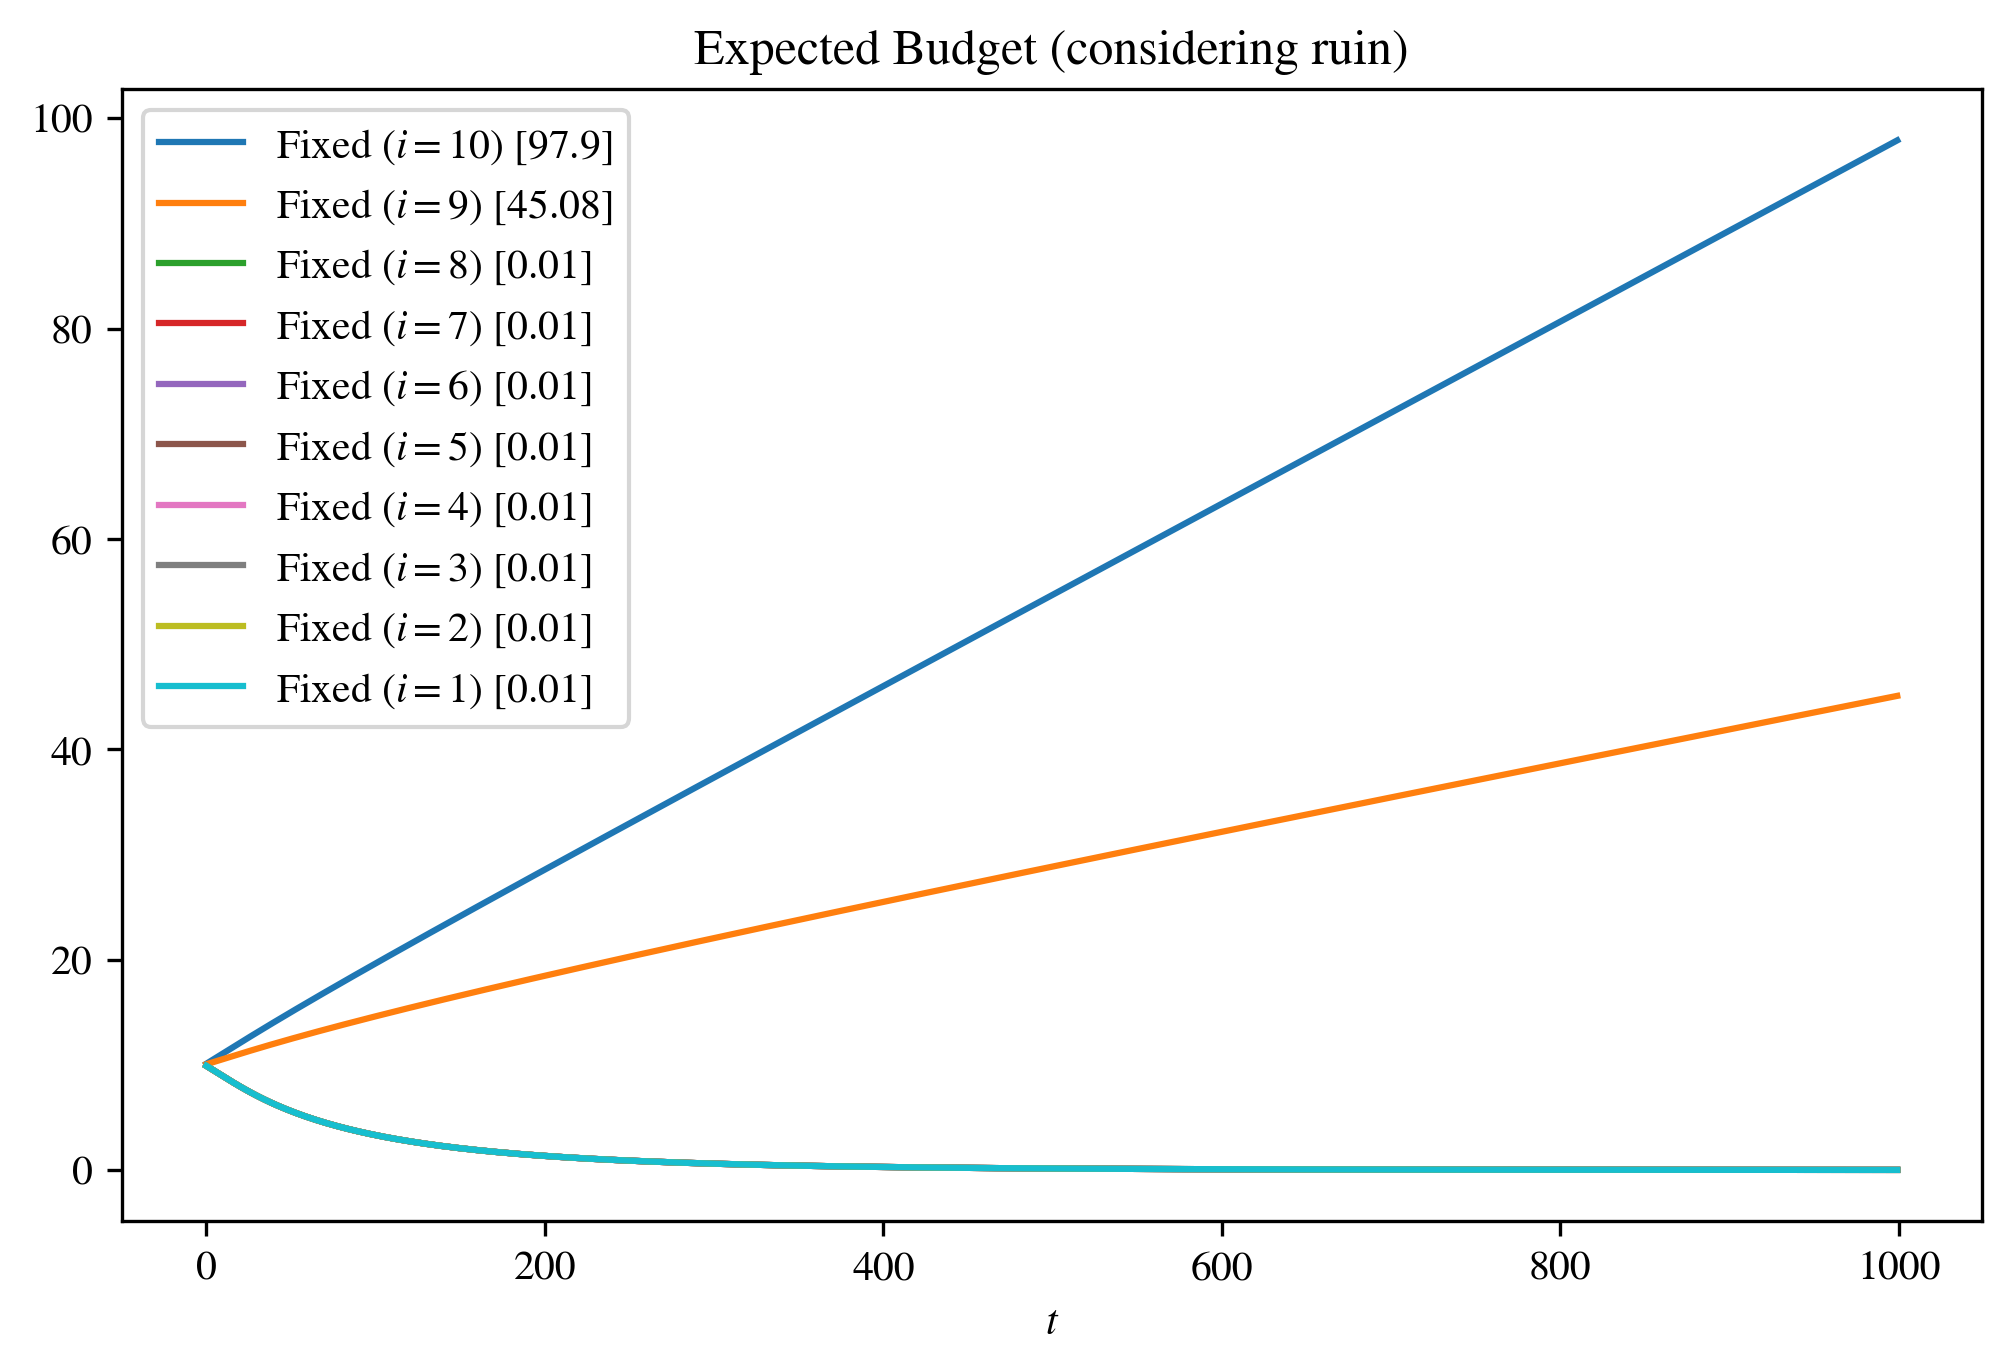

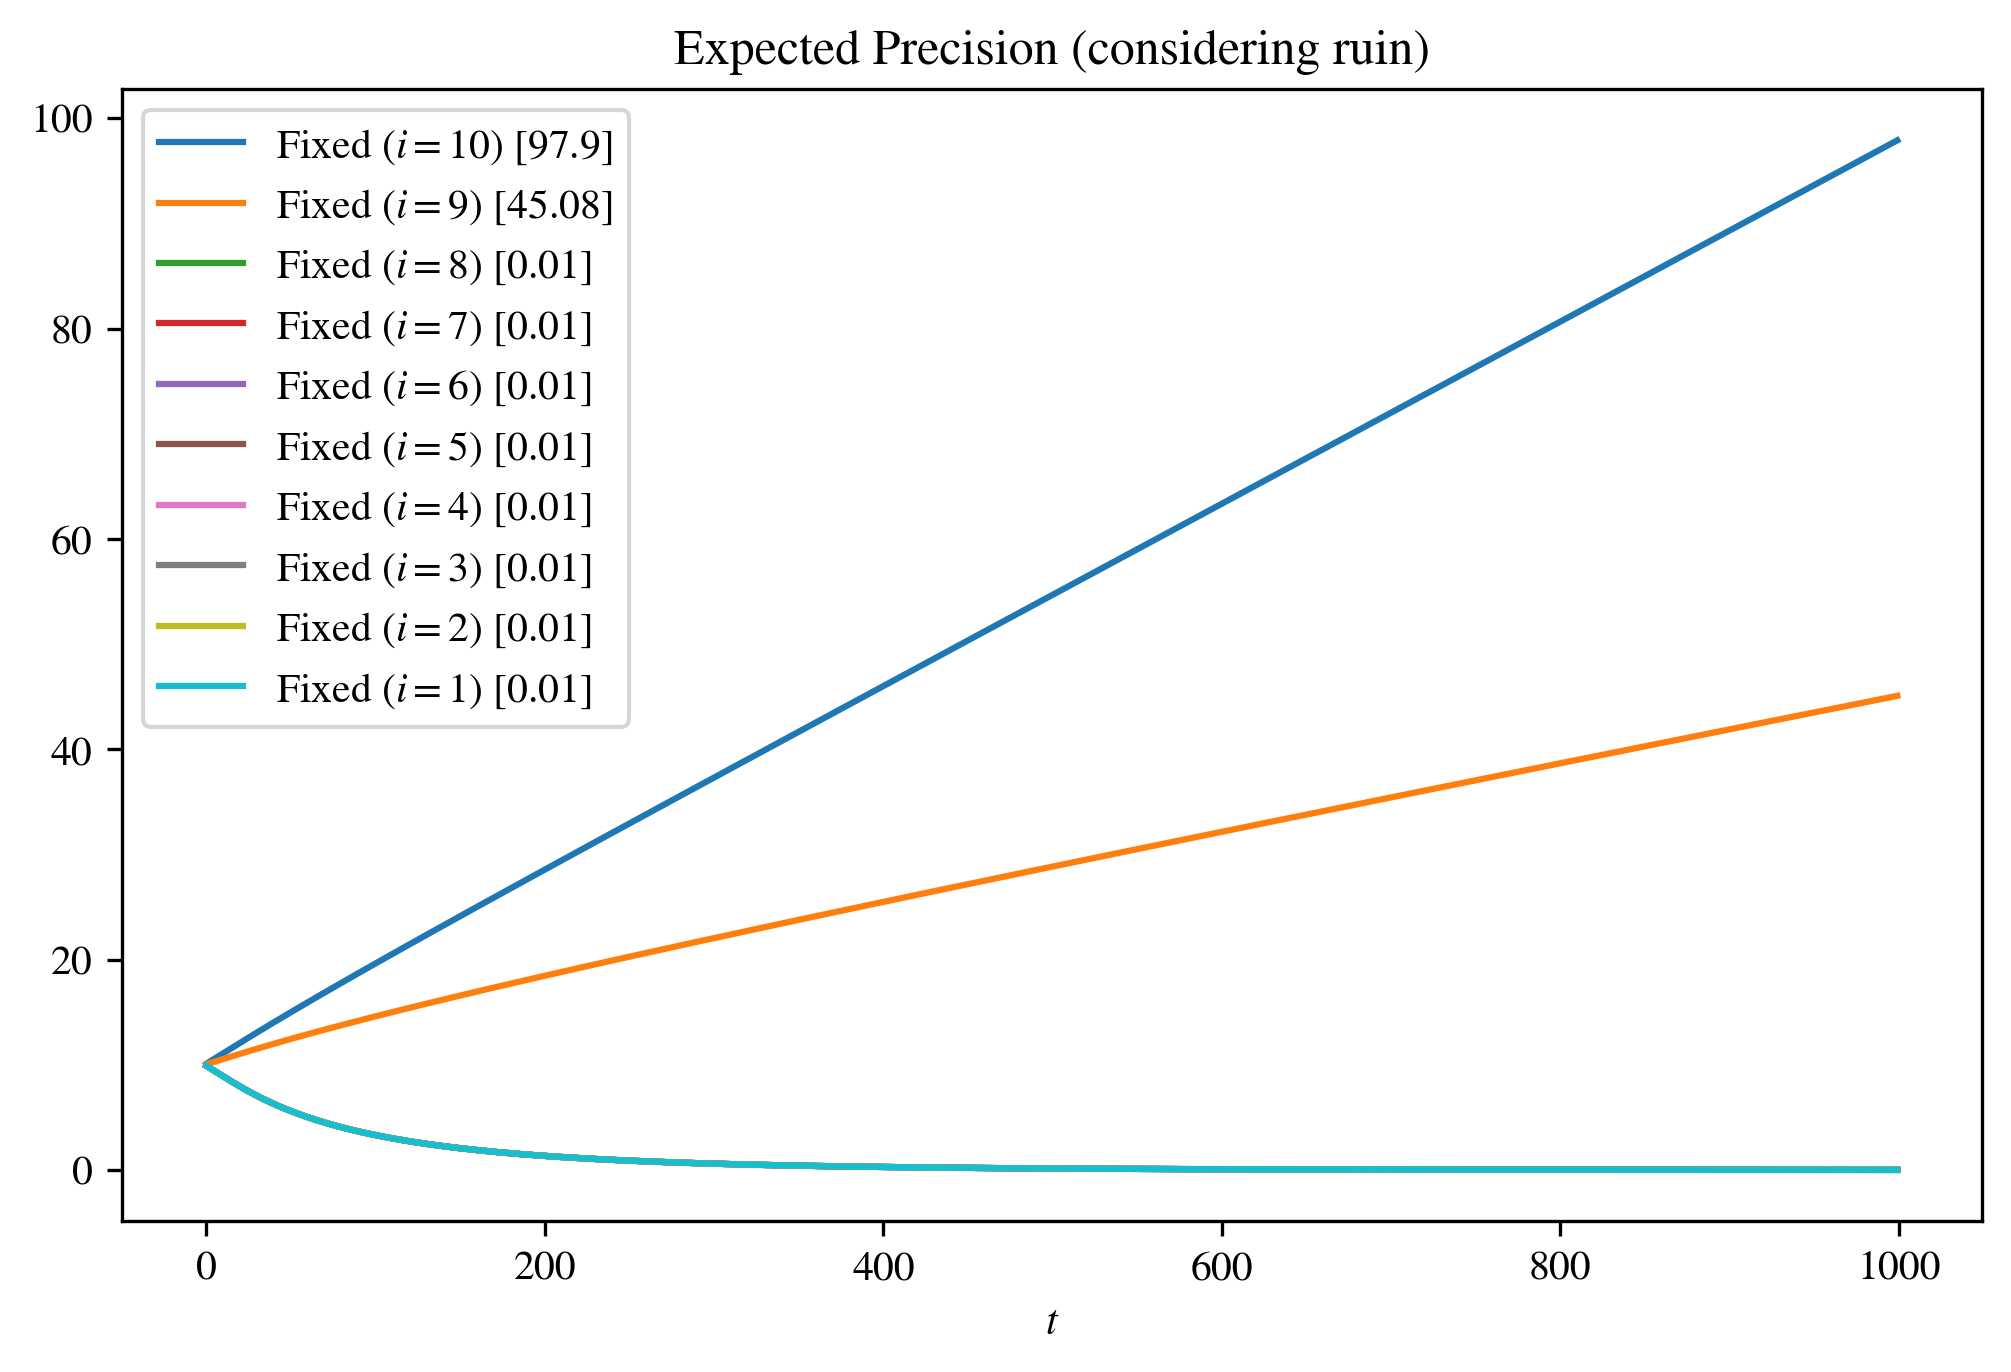

In [3]:
################################################################################
from math import comb, pow

def zcomb(n:int, k:int):
    #k and n must be naturals
    if (n >= k) and (k >= 0):
        return comb(n, k)
    else:
        return 0

################

def exact_ruin_dist(t, b, p=0.5):
    if (abs(b)>t) or ((t+b)%2):
        return 0
    else:
        #centered catalan triangle
        k = (t+b)//2
        n = k-1 #(t+b-2)//2
        m = (t-b)//2
        c = max(0, zcomb(n+m, m) - zcomb(n+m, m-1))   
        return c * pow(p, t-k) * pow(1-p, k)    

################

def ruin_dist(h, b, p=0.5):
    s = 0.0
    for t in range(h):
        s += exact_ruin_dist(t, b, p)
    return s    

###############

def prob_ruin_inf(p):
    return pow((1-p)/p,b_0)  if  p > 0.5  else  1.0

prob_ruin_at = np.zeros((k,h))
for i in range(k):
    p = p_arr[i]
    for t in range(h):
        prob_ruin_at[i,t] = exact_ruin_dist(t, b_0, p)

prob_ruin_until = np.cumsum(prob_ruin_at, axis=1)

expected_reward_at = np.zeros((k,h))
for i in range(k):
    p = p_arr[i]
    for t in range(h):
        expected_reward_at[i,t] = (1.0 - prob_ruin_until[i,t]) * (2*p-1)

expected_cum_reward = np.cumsum(expected_reward_at, axis=1)
        

###############

fig, ax = plt.subplots(1)
sim.plot(np.array([[1-prob_ruin_inf(p)]*h for p in p_arr]), title='Expected Survival Rate', ax=ax, line_properties=[{'ls':':'} for _ in range(k)], show=False, showlast='legend')
sim.plot(1-prob_ruin_until, ax=ax, line_properties=[{'label':''} for _ in range(k)], showlast='axis')
sim.plot(expected_reward_at, title='Expected Instant Reward (considering ruin)')
sim.plot(expected_cum_reward, title='Expected Cumulated Reward (considering ruin)')
sim.plot(expected_cum_reward + b_0, title='Expected Budget (considering ruin)')
sim.plot(expected_cum_reward + b_0, title='Expected Precision (considering ruin)')


In [8]:
sim.run(tqdm_leave=True)

  0%|          | 0/200 [00:00<?, ?it/s]

../../packages/magb\magb\simulator.py:309: RuntimeWarning: invalid value encountered in true_divide
  self.fr_a = sr_a / self.SR[:,:,-1,np.newaxis]


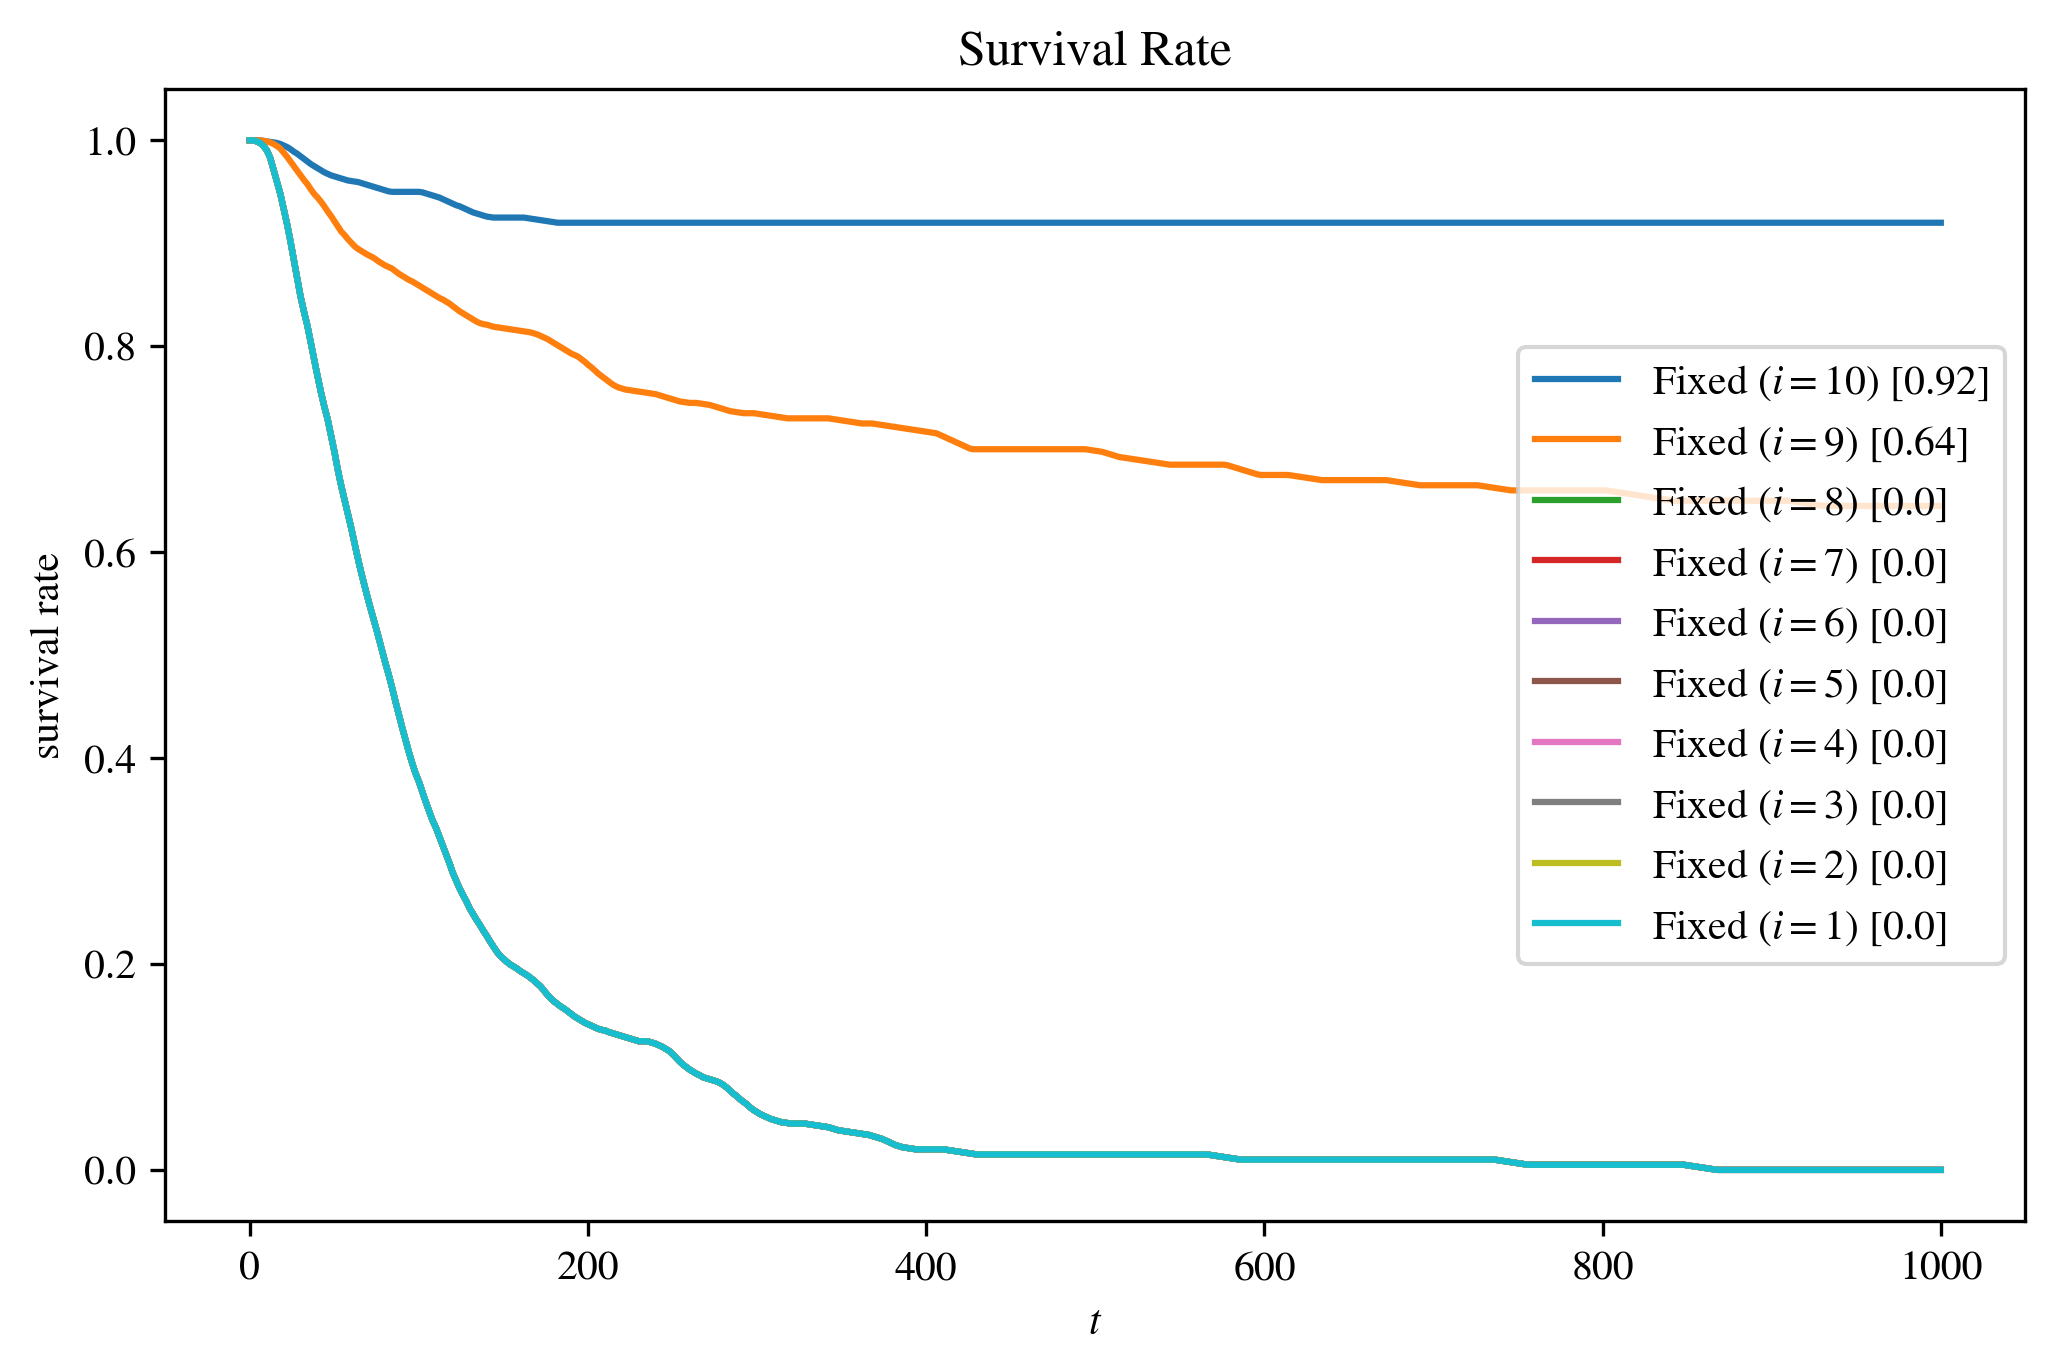

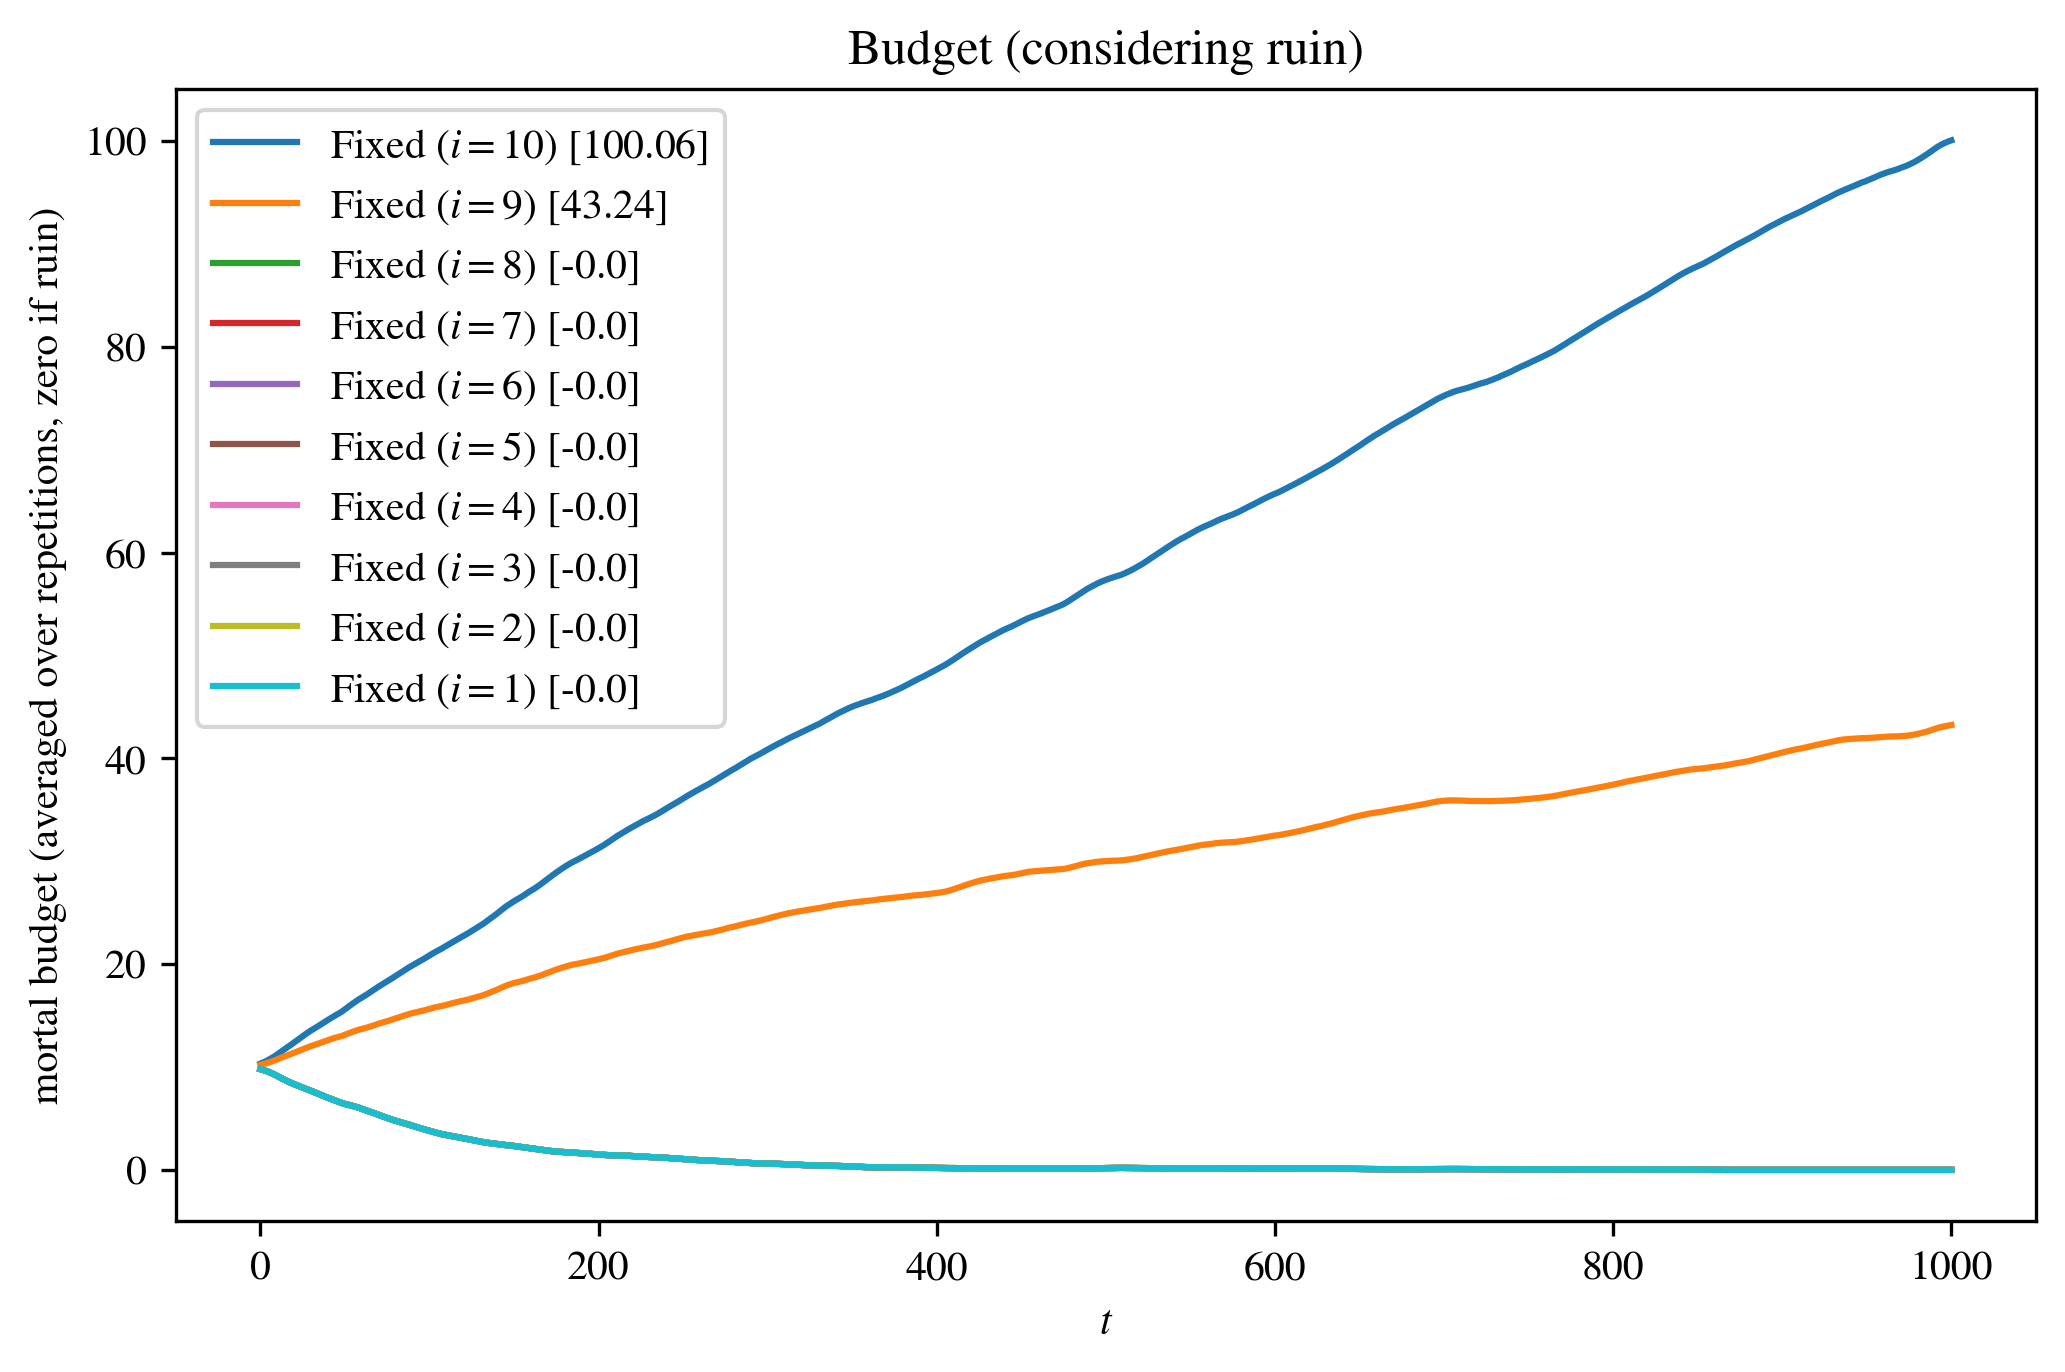

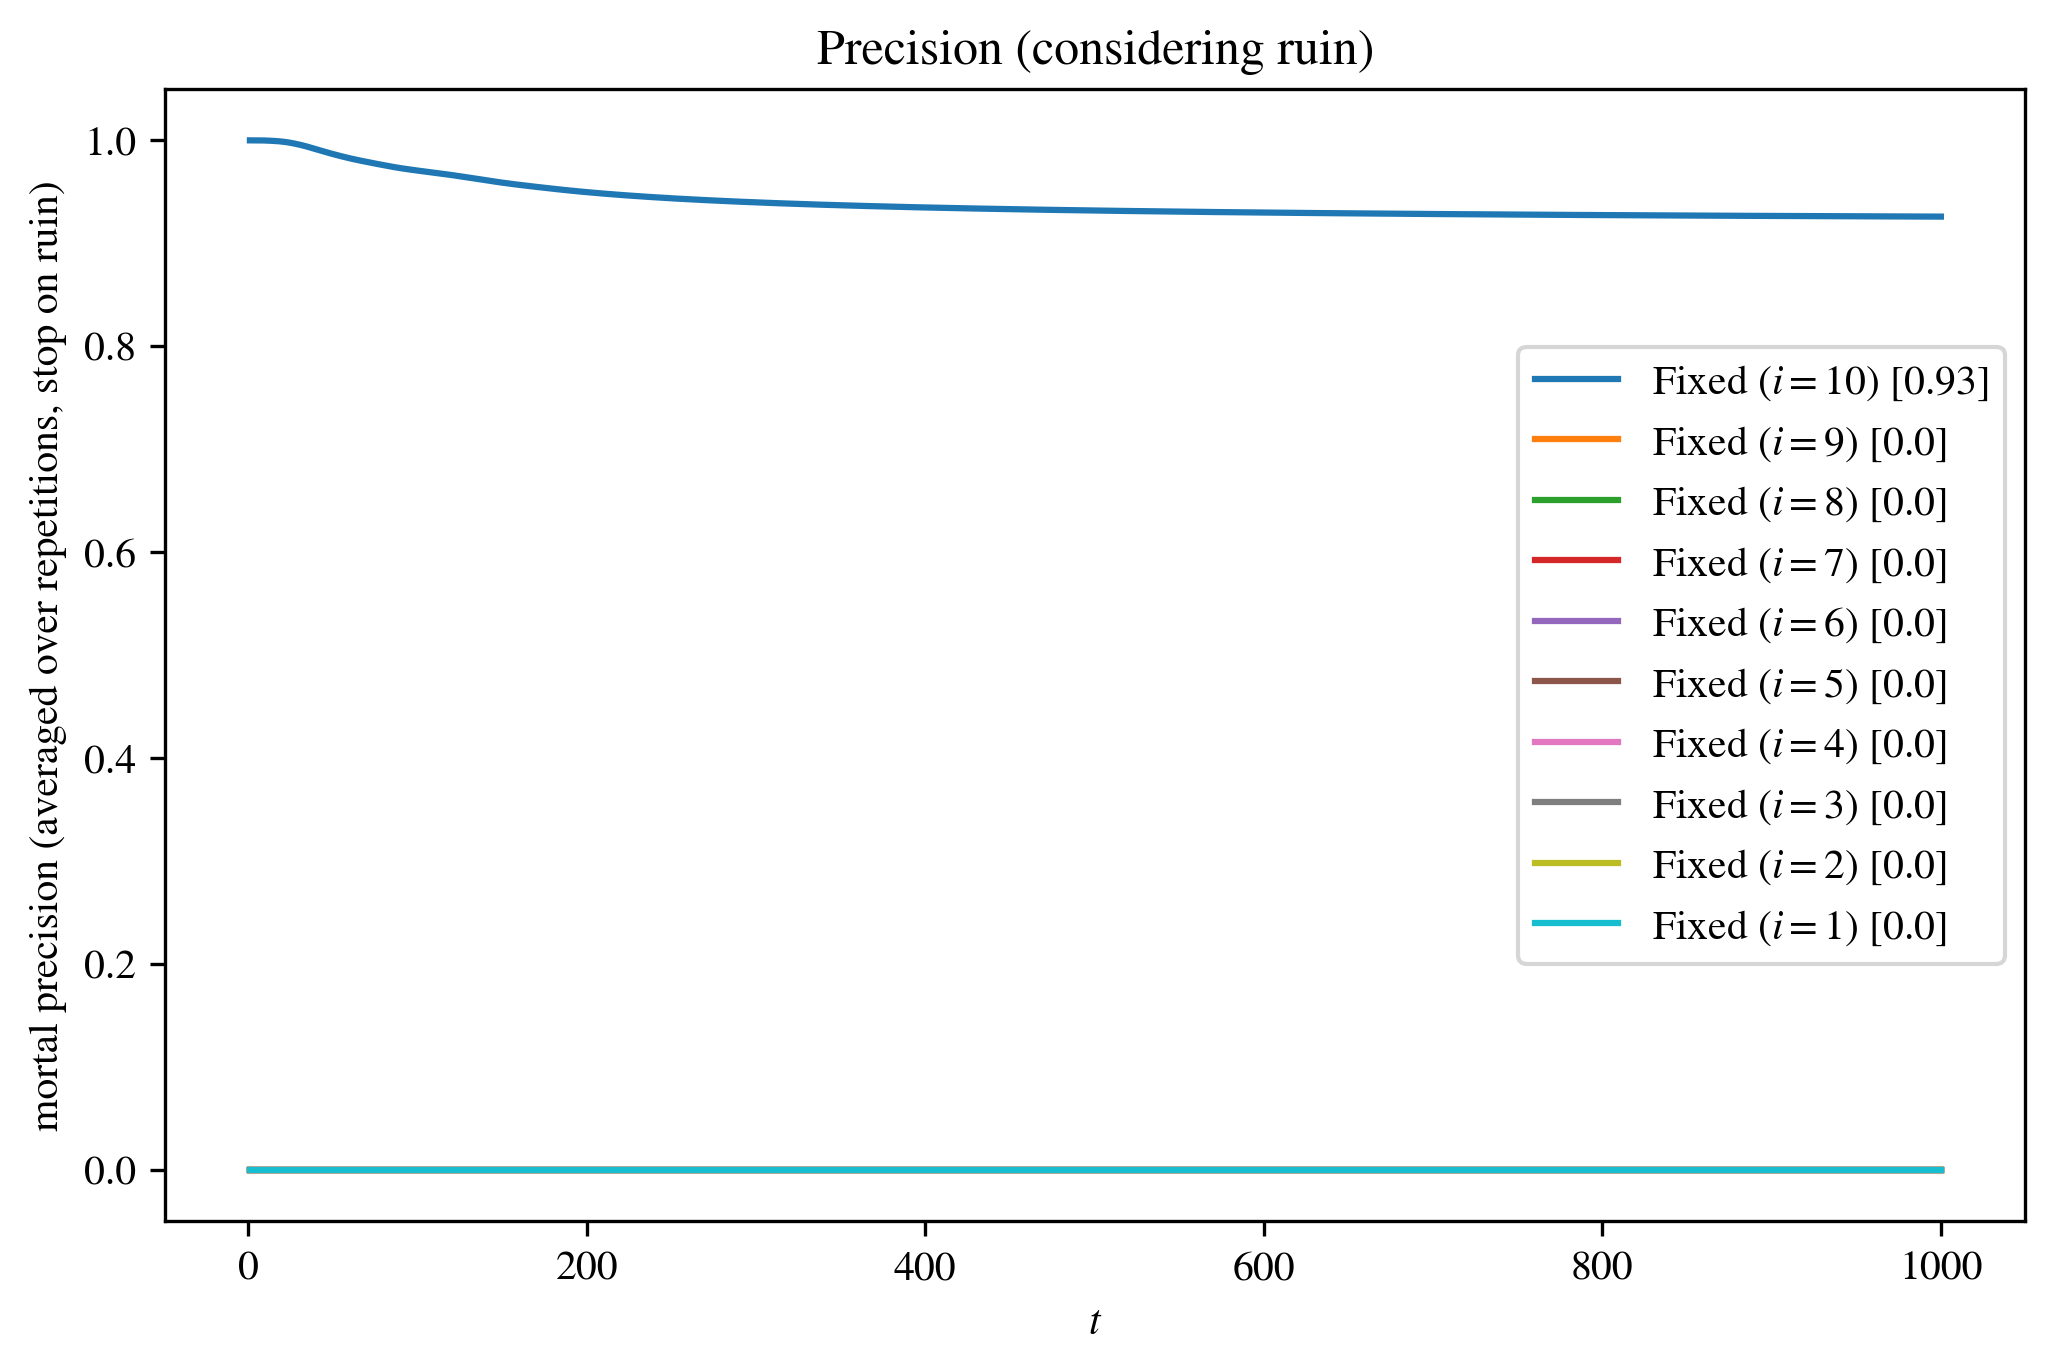

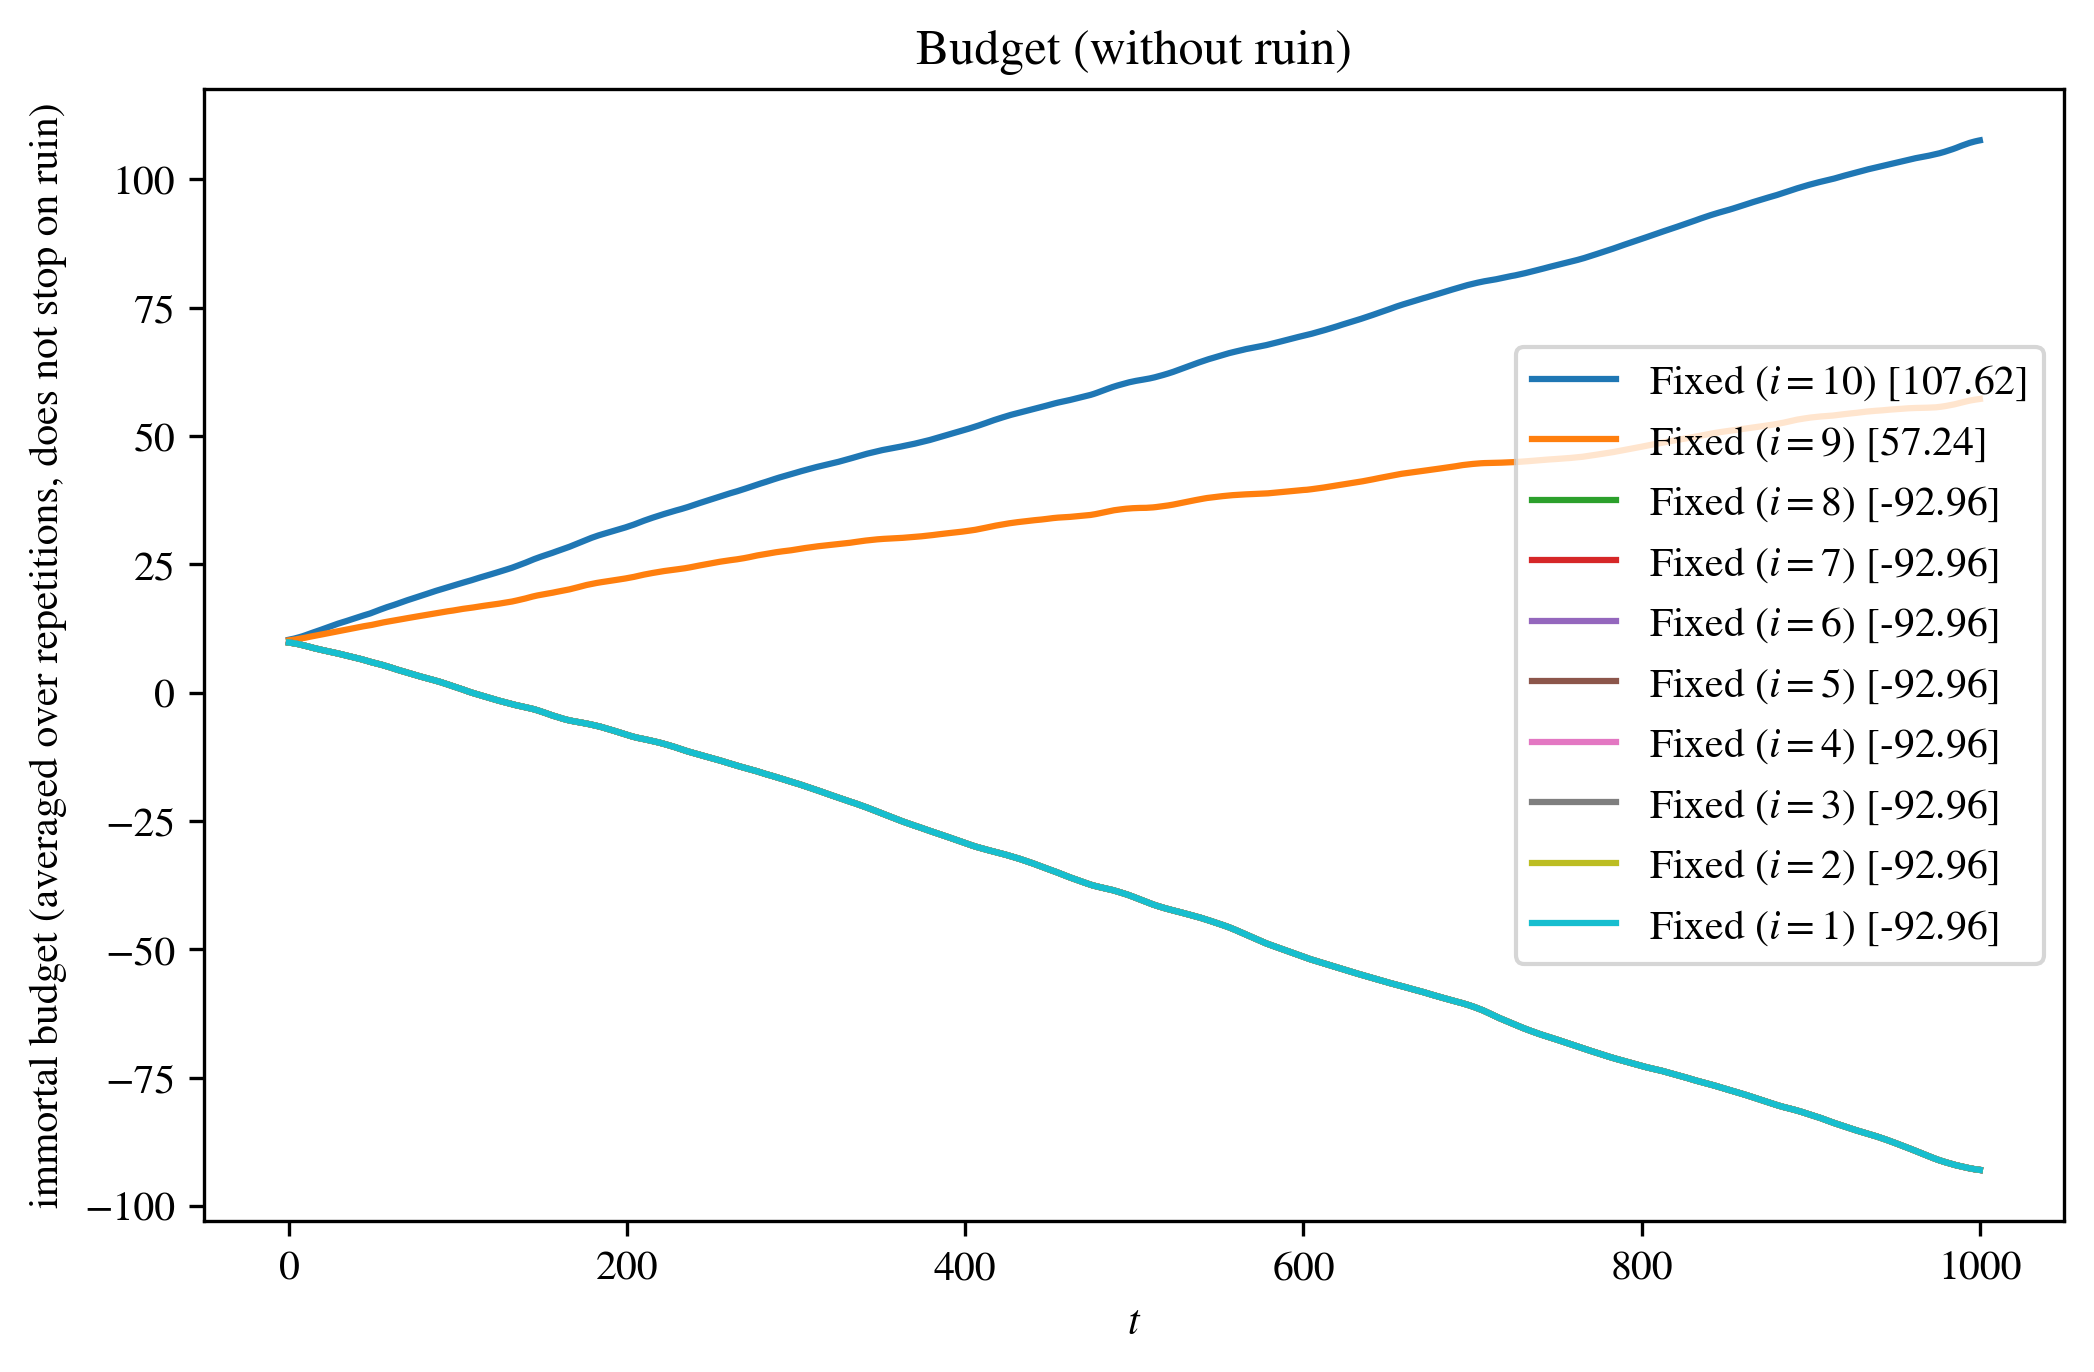

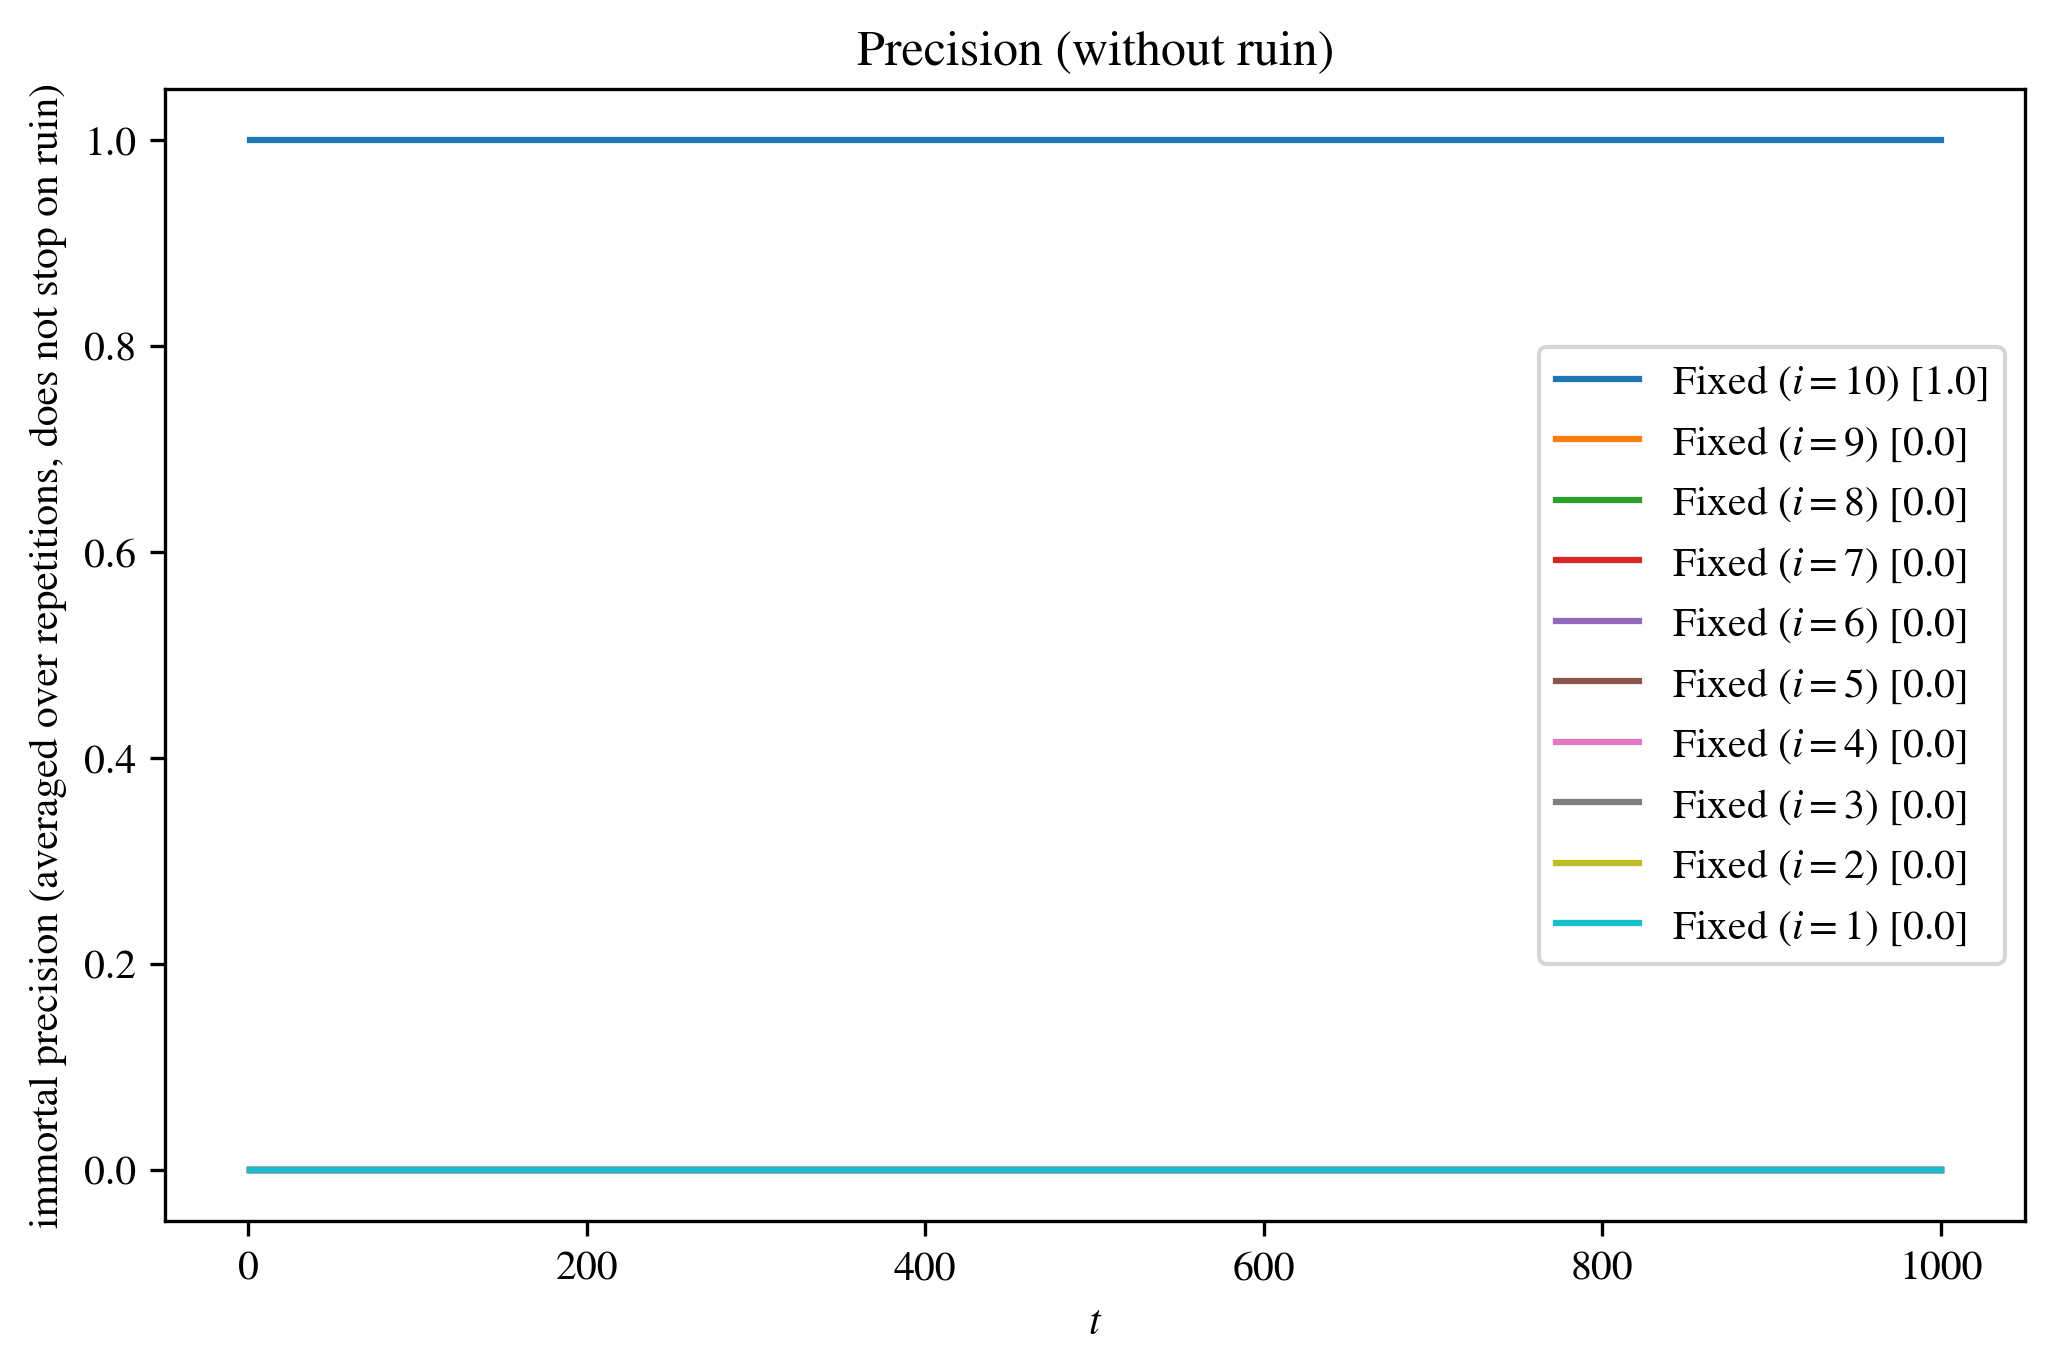

In [9]:
smooth_window = 2*k

sim.plot('survival', smooth_window=smooth_window)
sim.plot('mortal_budget', smooth_window=smooth_window)
sim.plot('mortal_precision', smooth_window=smooth_window)
sim.plot('immortal_budget', smooth_window=smooth_window)
sim.plot('immortal_precision', smooth_window=smooth_window)


In [10]:
#algorithms
algs = [
     #FixedPolicy(k, w=w, fixed_i=k, label="Best Arm"),
     #FixedPolicy(k, w=w, fixed_i=1, label="Worst Arm"),
     GreedyPolicy(k, w=w, style={'c':'r', 'ls':'-'}),
     EpsilonGreedyPolicy(k, w=w, eps=0.01, style={'c':'g', 'ls':'-', 'lw':1}), 
     EpsilonGreedyPolicy(k, w=w, eps=0.05, style={'c':'g', 'ls':'-', 'lw':1}), 
     EpsilonGreedyPolicy(k, w=w, eps=0.1,  style={'c':'g', 'ls':'-', 'lw':1}), 
     EpsilonGreedyPolicy(k, w=w, eps=0.01, style={'c':'g', 'ls':'--', 'lw':1}, b_0=b_0, omega=omega), 
     EpsilonGreedyPolicy(k, w=w, eps=0.05, style={'c':'g', 'ls':'--', 'lw':1}, b_0=b_0, omega=omega), 
     EpsilonGreedyPolicy(k, w=w, eps=0.1,  style={'c':'g', 'ls':'--', 'lw':1}, b_0=b_0, omega=omega), 
     SoftMaxPolicy(k, w=w, eta=0.01,  style={'c':'y', 'ls':'-', 'lw':1}), 
     SoftMaxPolicy(k, w=w, eta=0.1,   style={'c':'y', 'ls':'-', 'lw':1}), 
     SoftMaxPolicy(k, w=w, eta=0.5,   style={'c':'y', 'ls':'-', 'lw':1}), 
     SoftMaxPolicy(k, w=w, eta=1.0,   style={'c':'y', 'ls':'-', 'lw':1}), 
     SoftMaxPolicy(k, w=w, eta=2.0,   style={'c':'y', 'ls':'-', 'lw':1}), 
     SoftMaxPolicy(k, w=w, eta=0.01,  style={'c':'y', 'ls':':', 'lw':1}, b_0=b_0, omega=omega), 
     SoftMaxPolicy(k, w=w, eta=0.1,   style={'c':'y', 'ls':':', 'lw':1}, b_0=b_0, omega=omega), 
     SoftMaxPolicy(k, w=w, eta=0.5,   style={'c':'y', 'ls':':', 'lw':1}, b_0=b_0, omega=omega), 
     SoftMaxPolicy(k, w=w, eta=1.0,   style={'c':'y', 'ls':':', 'lw':1}, b_0=b_0, omega=omega), 
     SoftMaxPolicy(k, w=w, eta=2.0,   style={'c':'y', 'ls':':', 'lw':1}, b_0=b_0, omega=omega), 
     UCBPolicy(k, w=w, r_min=-1.0, r_max=1.0, alpha=0.05, style={'c':'b', 'ls':'-', 'lw':1}),
     UCBPolicy(k, w=w, r_min=-1.0, r_max=1.0, alpha=0.1,  style={'c':'b', 'ls':'-', 'lw':1}),
     UCBPolicy(k, w=w, r_min=-1.0, r_max=1.0, alpha=0.5,  style={'c':'b', 'ls':'-', 'lw':1}),
     UCBPolicy(k, w=w, r_min=-1.0, r_max=1.0, alpha=1.0,  style={'c':'b', 'ls':'-', 'lw':1}),
     UCBPolicy(k, w=w, r_min=-1.0, r_max=1.0, alpha=2.0,  style={'c':'b', 'ls':'-', 'lw':1}),
     UCBPolicy(k, w=w, r_min=-1.0, r_max=1.0, alpha=0.05, style={'c':'b', 'ls':'--', 'lw':1}, b_0=b_0, omega=omega),
     UCBPolicy(k, w=w, r_min=-1.0, r_max=1.0, alpha=0.1,  style={'c':'b', 'ls':'--', 'lw':1}, b_0=b_0, omega=omega),
     UCBPolicy(k, w=w, r_min=-1.0, r_max=1.0, alpha=0.5,  style={'c':'b', 'ls':'--', 'lw':1}, b_0=b_0, omega=omega),
     UCBPolicy(k, w=w, r_min=-1.0, r_max=1.0, alpha=1.0,  style={'c':'b', 'ls':'--', 'lw':1}, b_0=b_0, omega=omega),
     UCBPolicy(k, w=w, r_min=-1.0, r_max=1.0, alpha=2.0,  style={'c':'b', 'ls':'--', 'lw':1}, b_0=b_0, omega=omega),
     ThompsonPolicy(k, w=w, style={'c':'m', 'ls':'-', 'lw':1}),
     ThompsonPolicy(k, w=w, style={'c':'m', 'ls':'--', 'lw':1}, b_0=b_0, omega=omega),
     BayesUCBPolicy(k, w=w, style={'c':'m', 'ls':'-', 'lw':1}),
     BayesUCBPolicy(k, w=w, style={'c':'m', 'ls':'--', 'lw':1}, b_0=b_0, omega=omega),
    ]

m = len(algs)

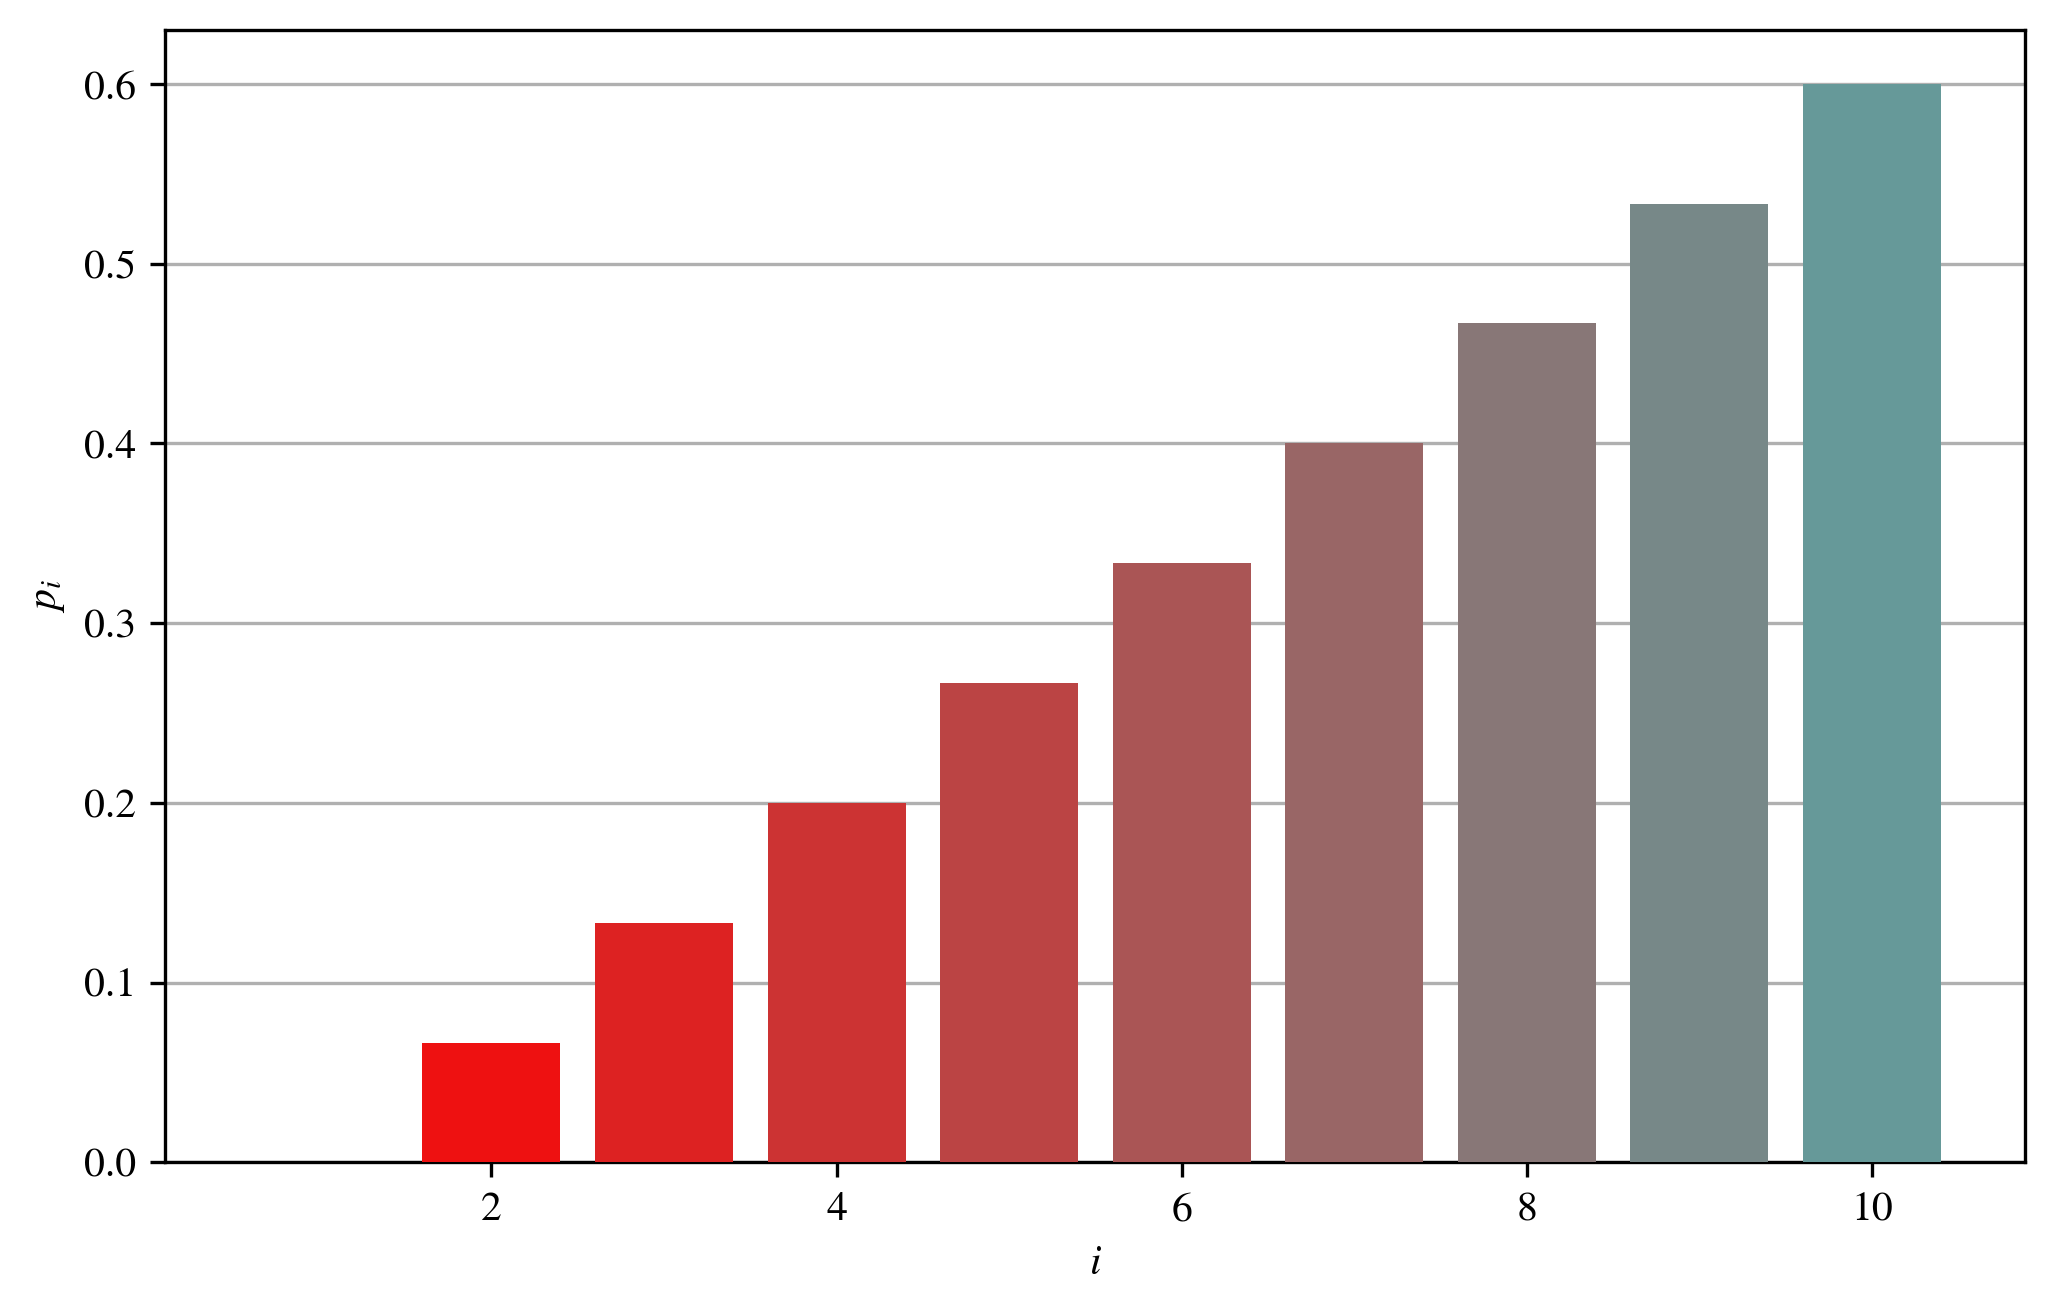

  0%|          | 0/200 [00:00<?, ?it/s]

../../packages/magb\magb\simulator.py:309: RuntimeWarning: divide by zero encountered in true_divide
  self.fr_a = sr_a / self.SR[:,:,-1,np.newaxis]
../../packages/magb\magb\simulator.py:309: RuntimeWarning: invalid value encountered in true_divide
  self.fr_a = sr_a / self.SR[:,:,-1,np.newaxis]
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


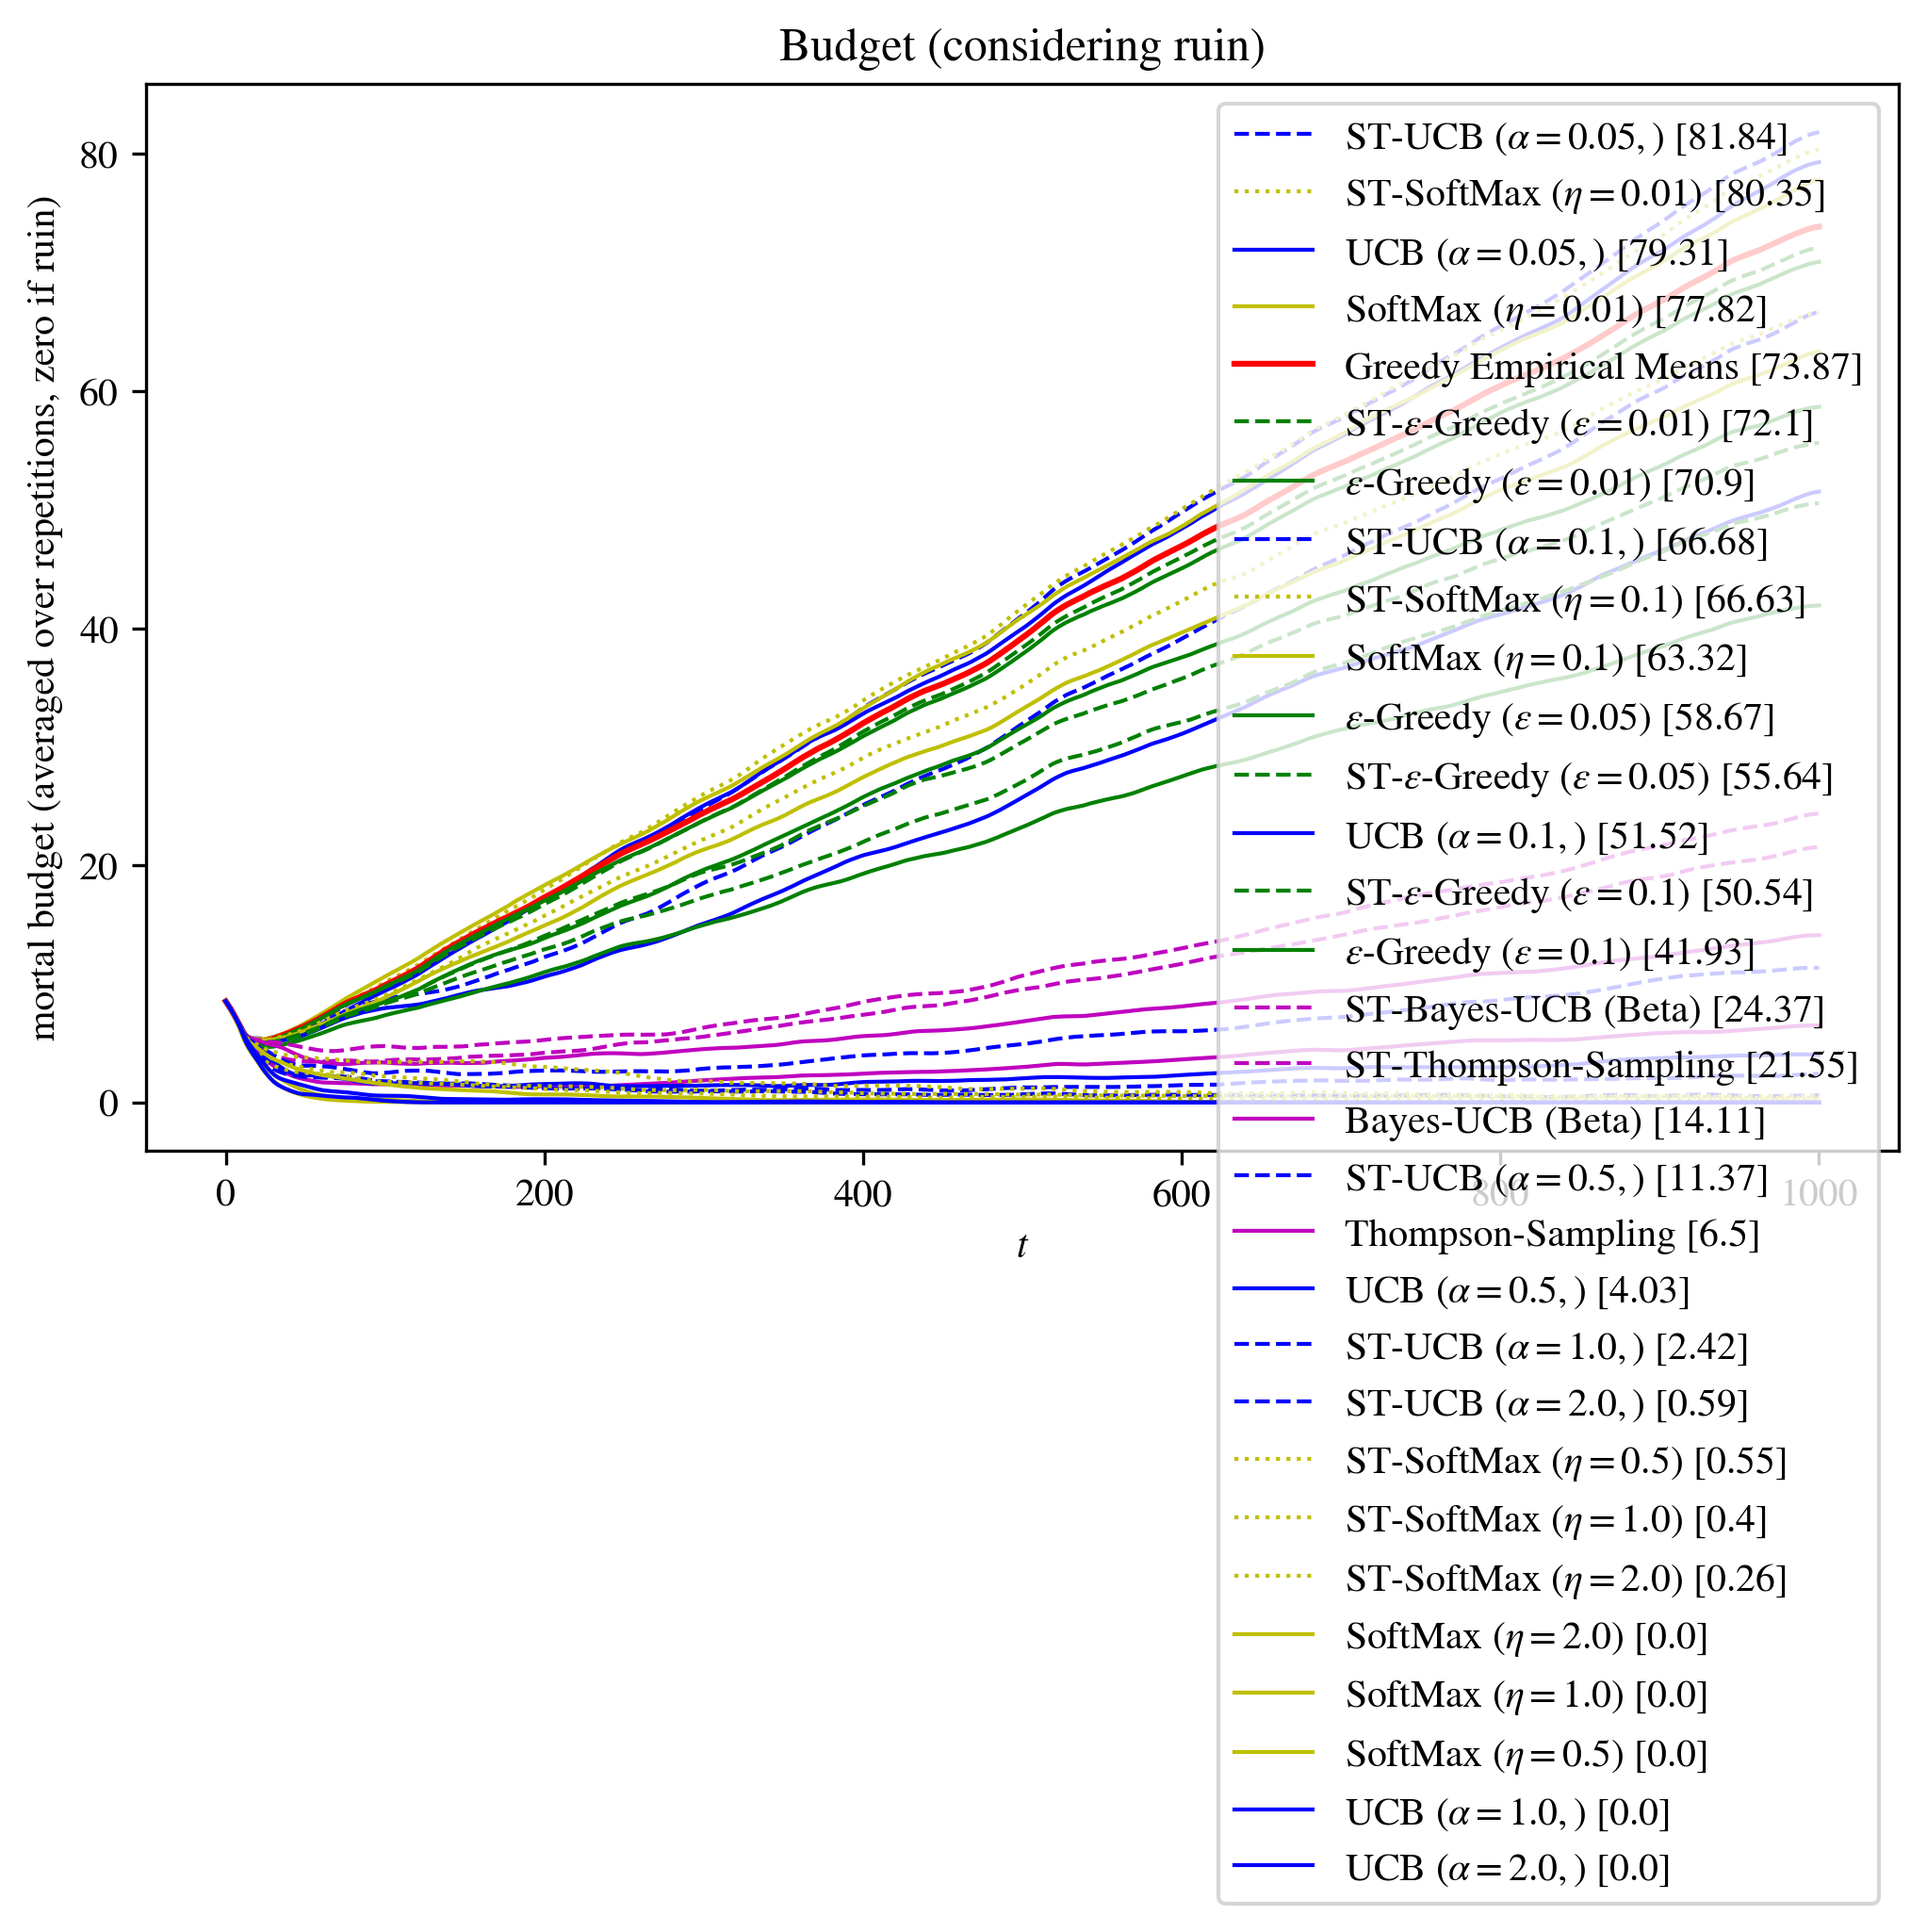

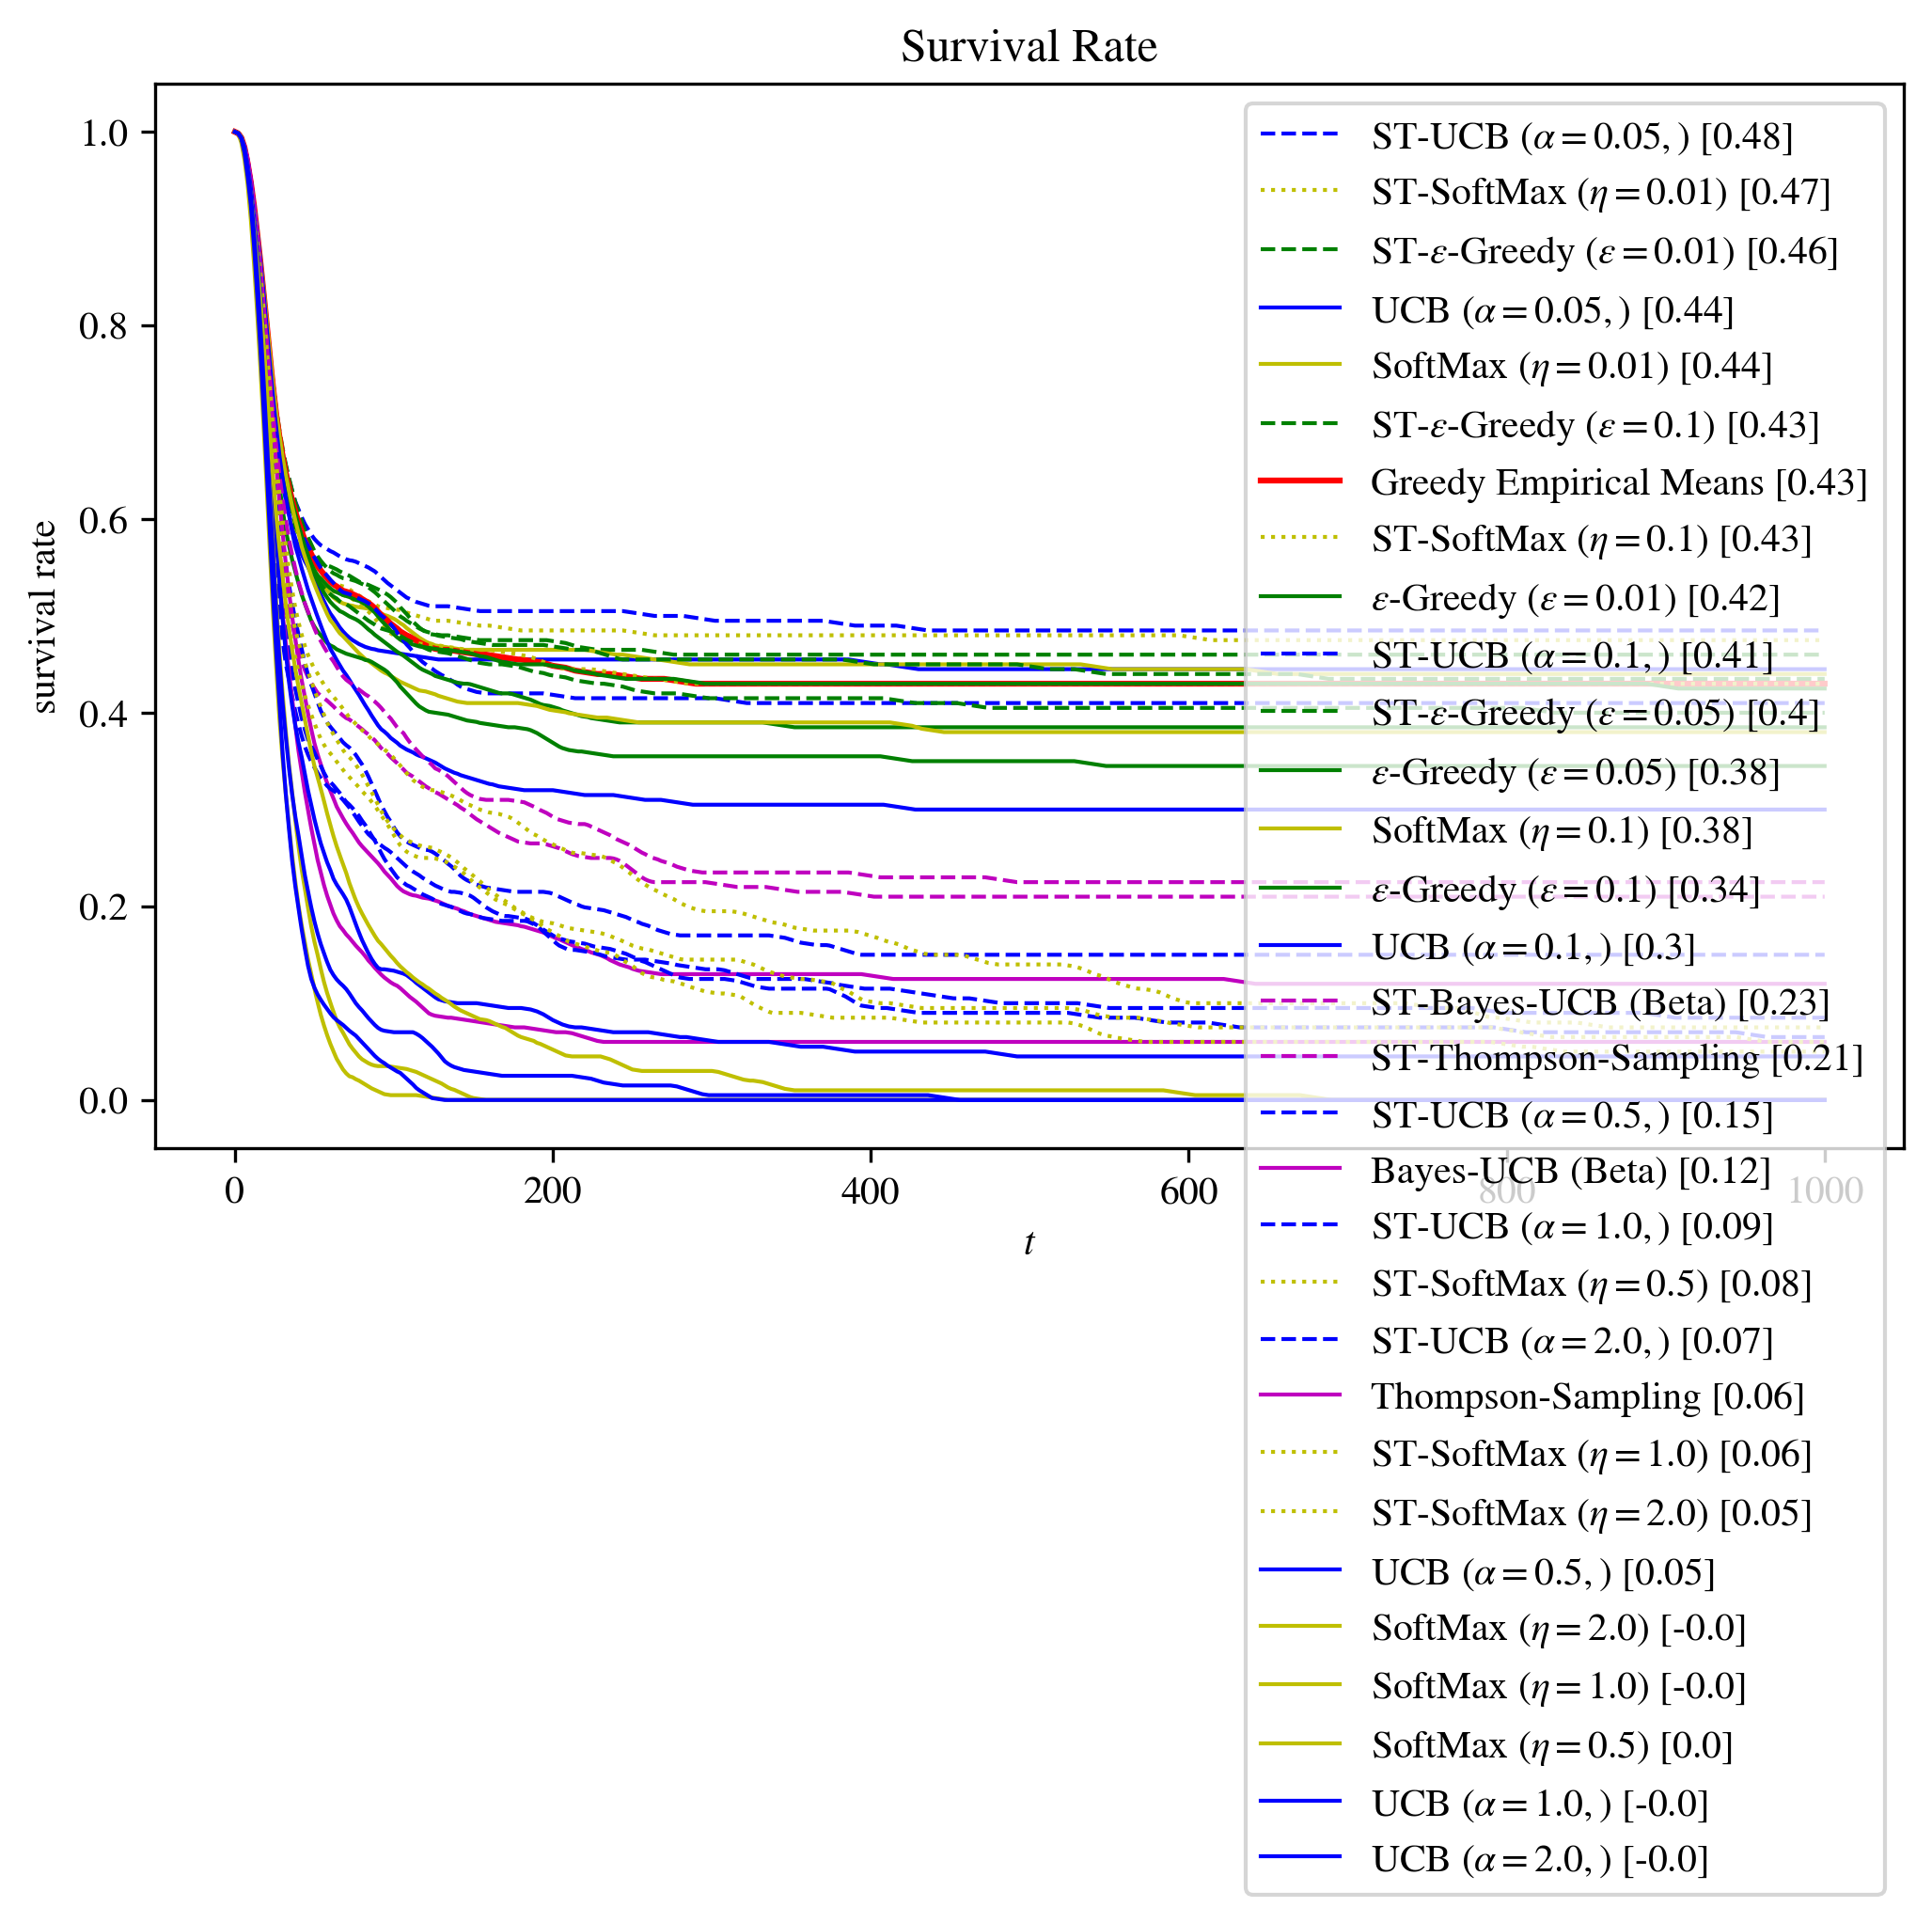

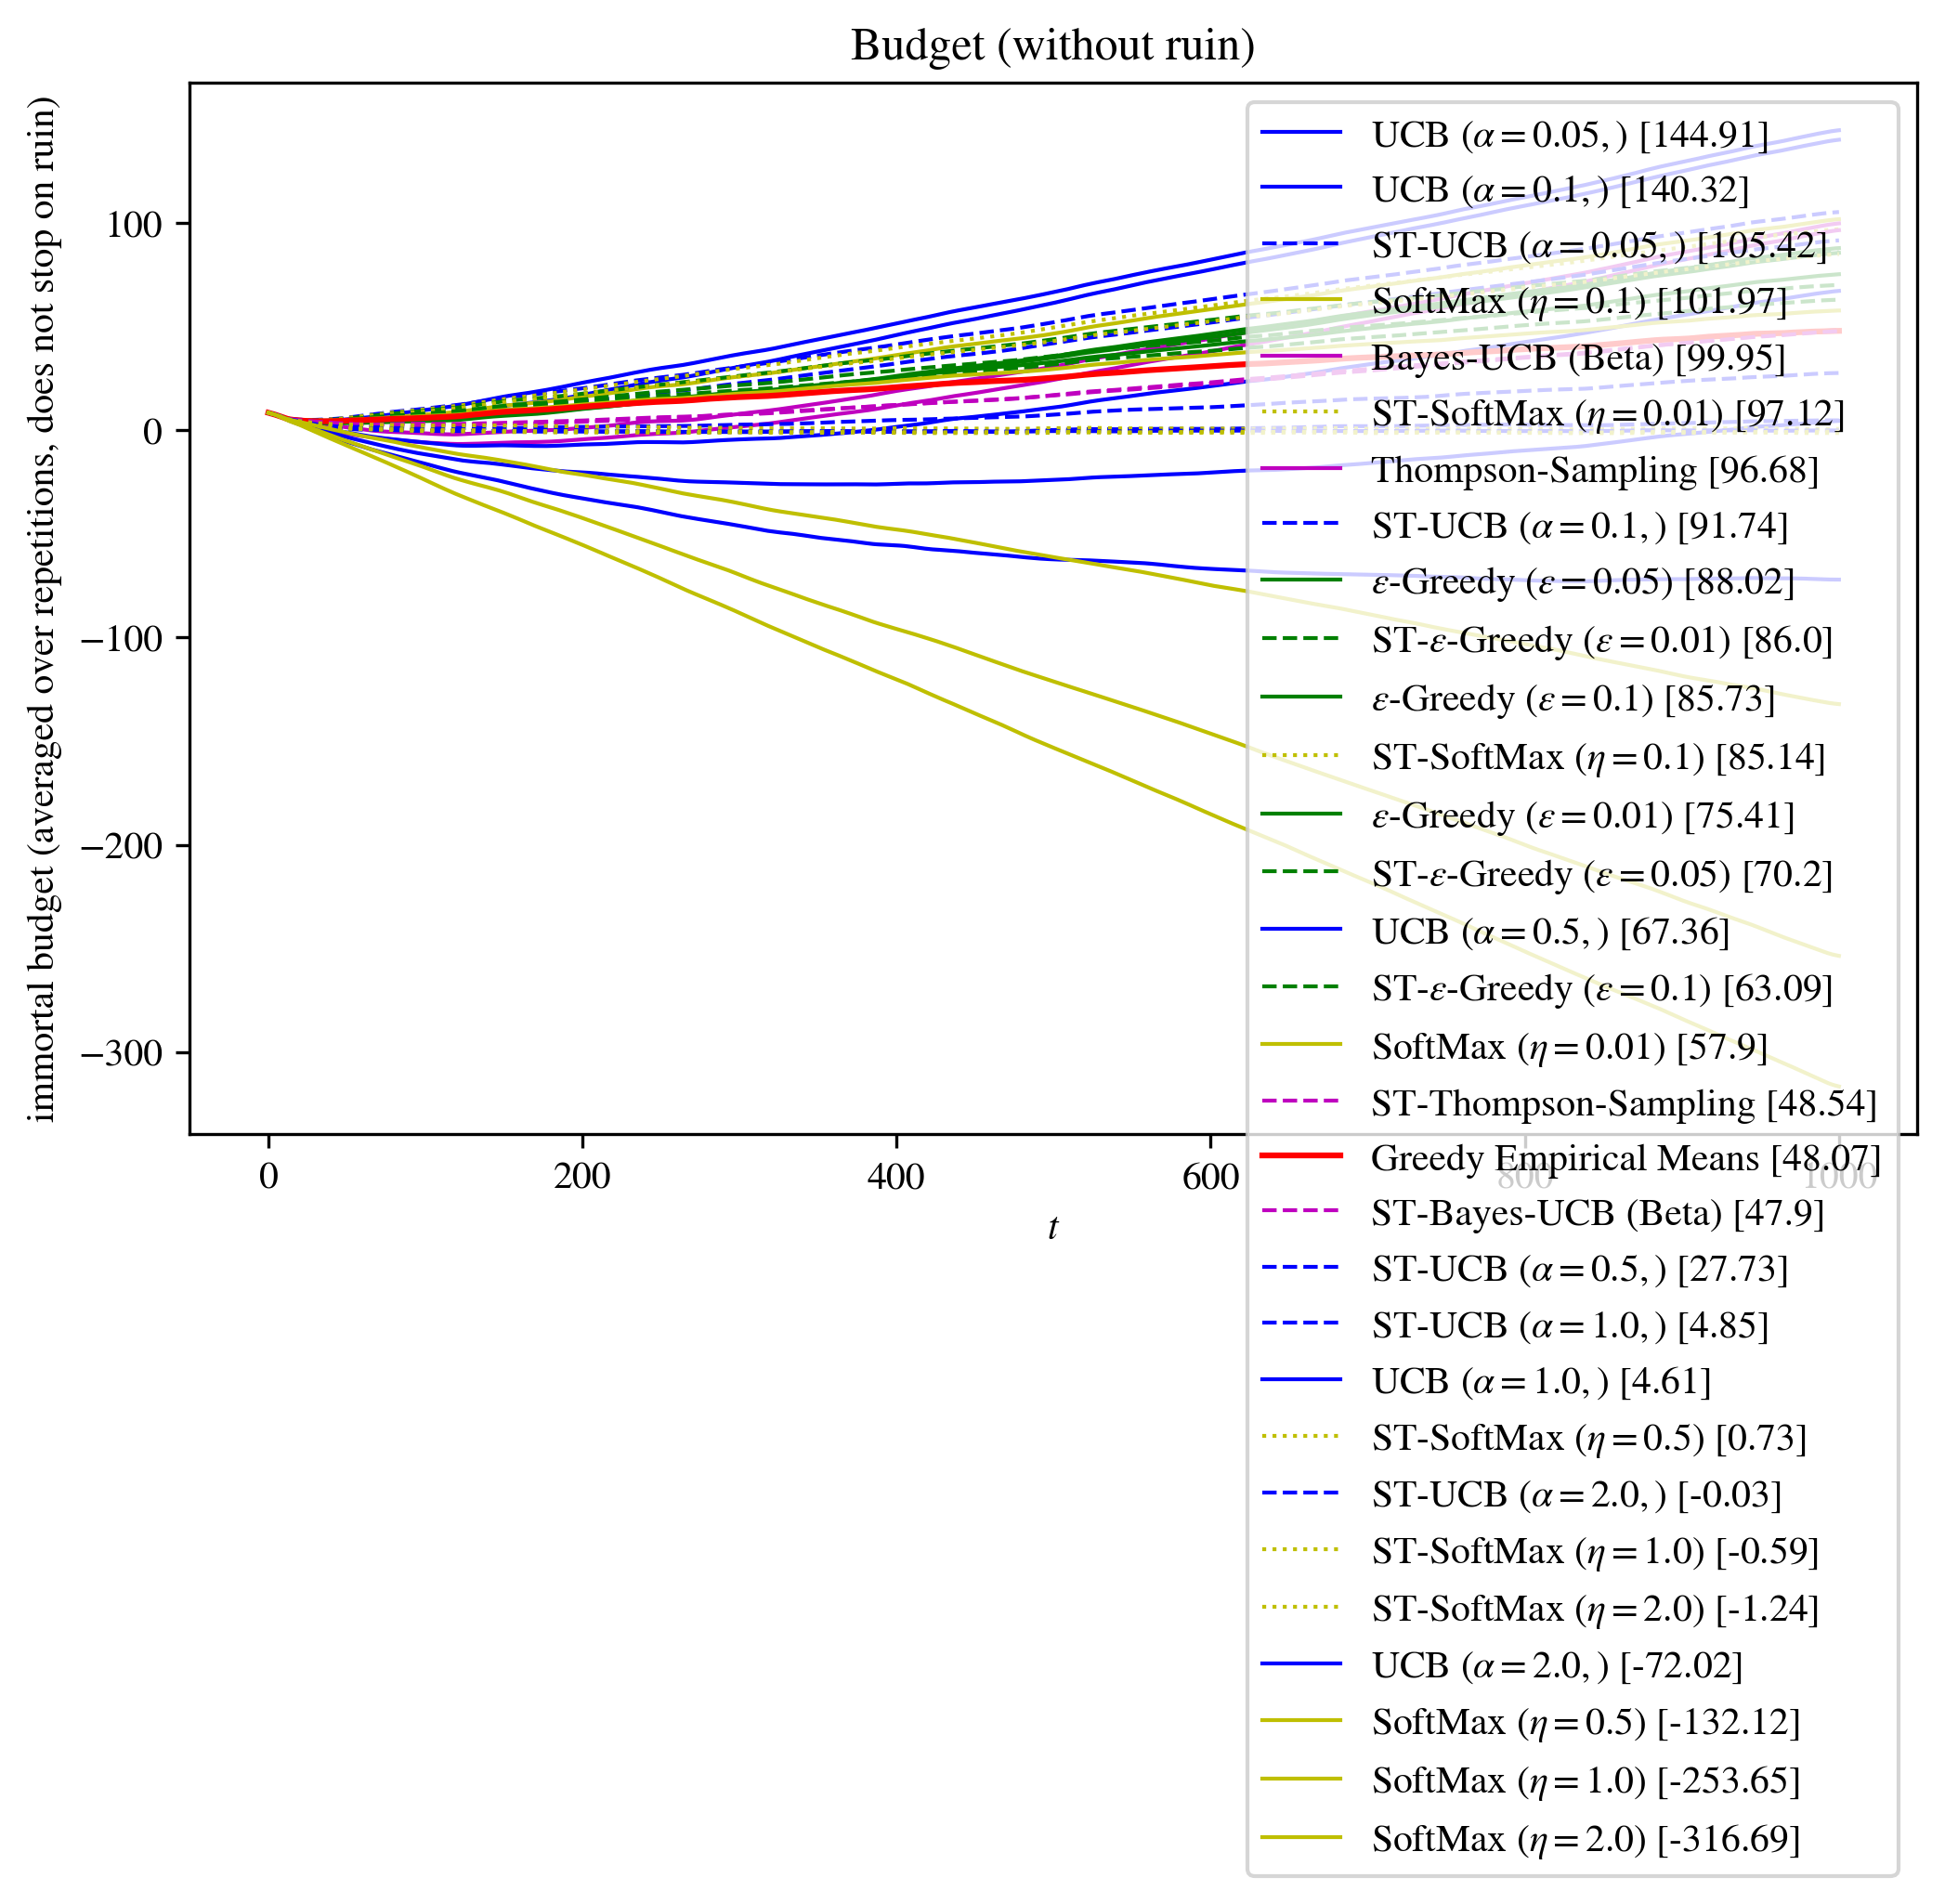

Unknown plot.


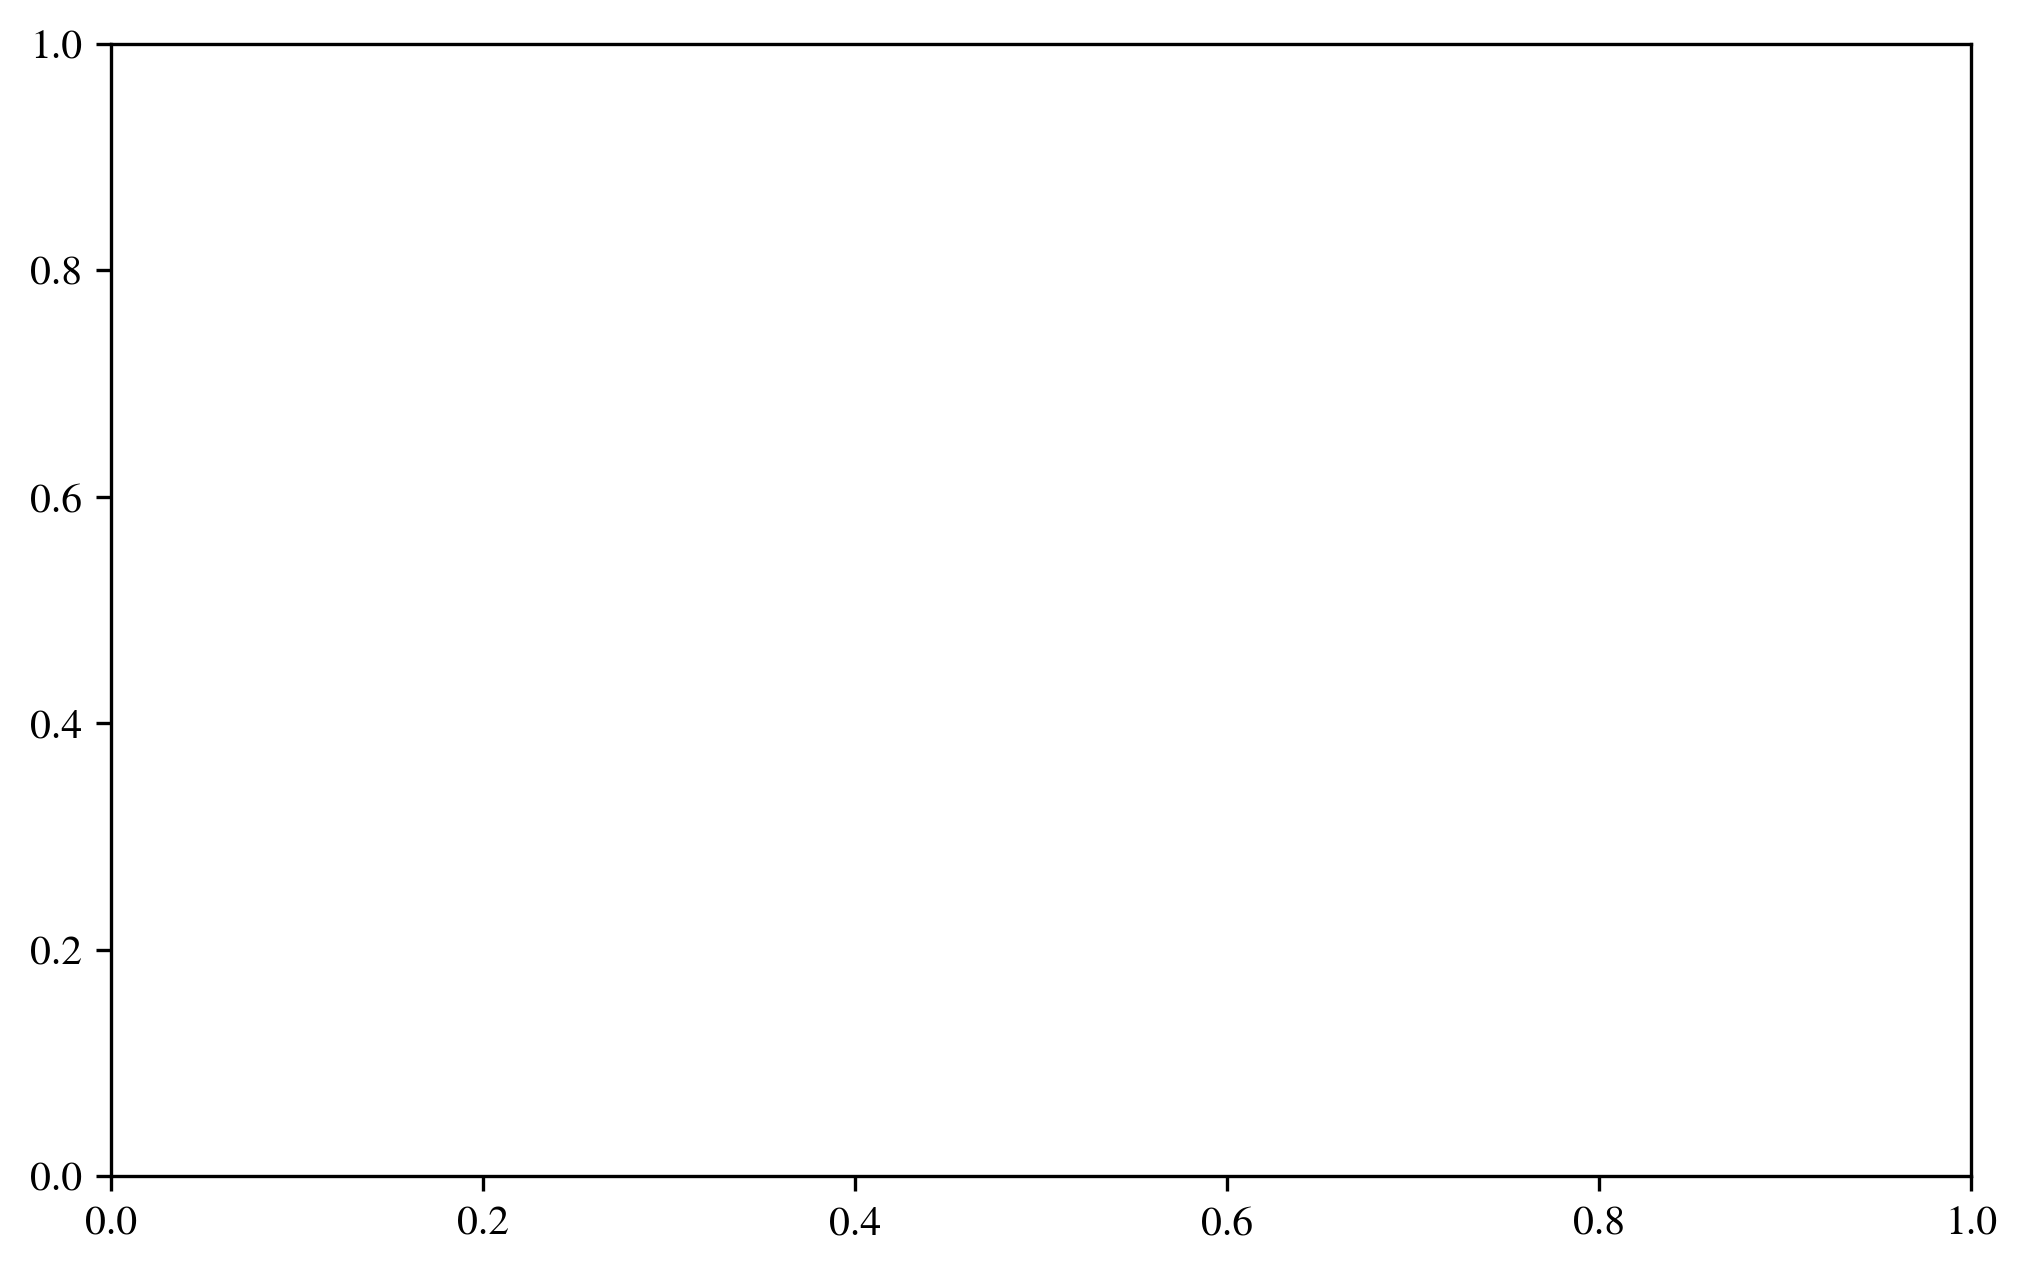

In [11]:
k = 10
p_arr = np.linspace(0.0, 0.6, k)

#Bernoulli
arms = [BernoulliArm(p, minr=-1.0, maxr=+1.0) for p in p_arr]

fig, ax = plt.subplots(1)
ax.grid(visible=True, which='major', axis='y', zorder=0)
ax.set_xlabel('$i$')
ax.set_ylabel('$p_i$')
for i, p in enumerate(p_arr):
    ax.bar(i+1, p, zorder=3, color=(1-p, p, p, 1.0))
plt.show()

sim6 = SMAB(arms, algs, h, b_0, n=n, use_multiprocess=False)
sim6.run(tqdm_leave=True)

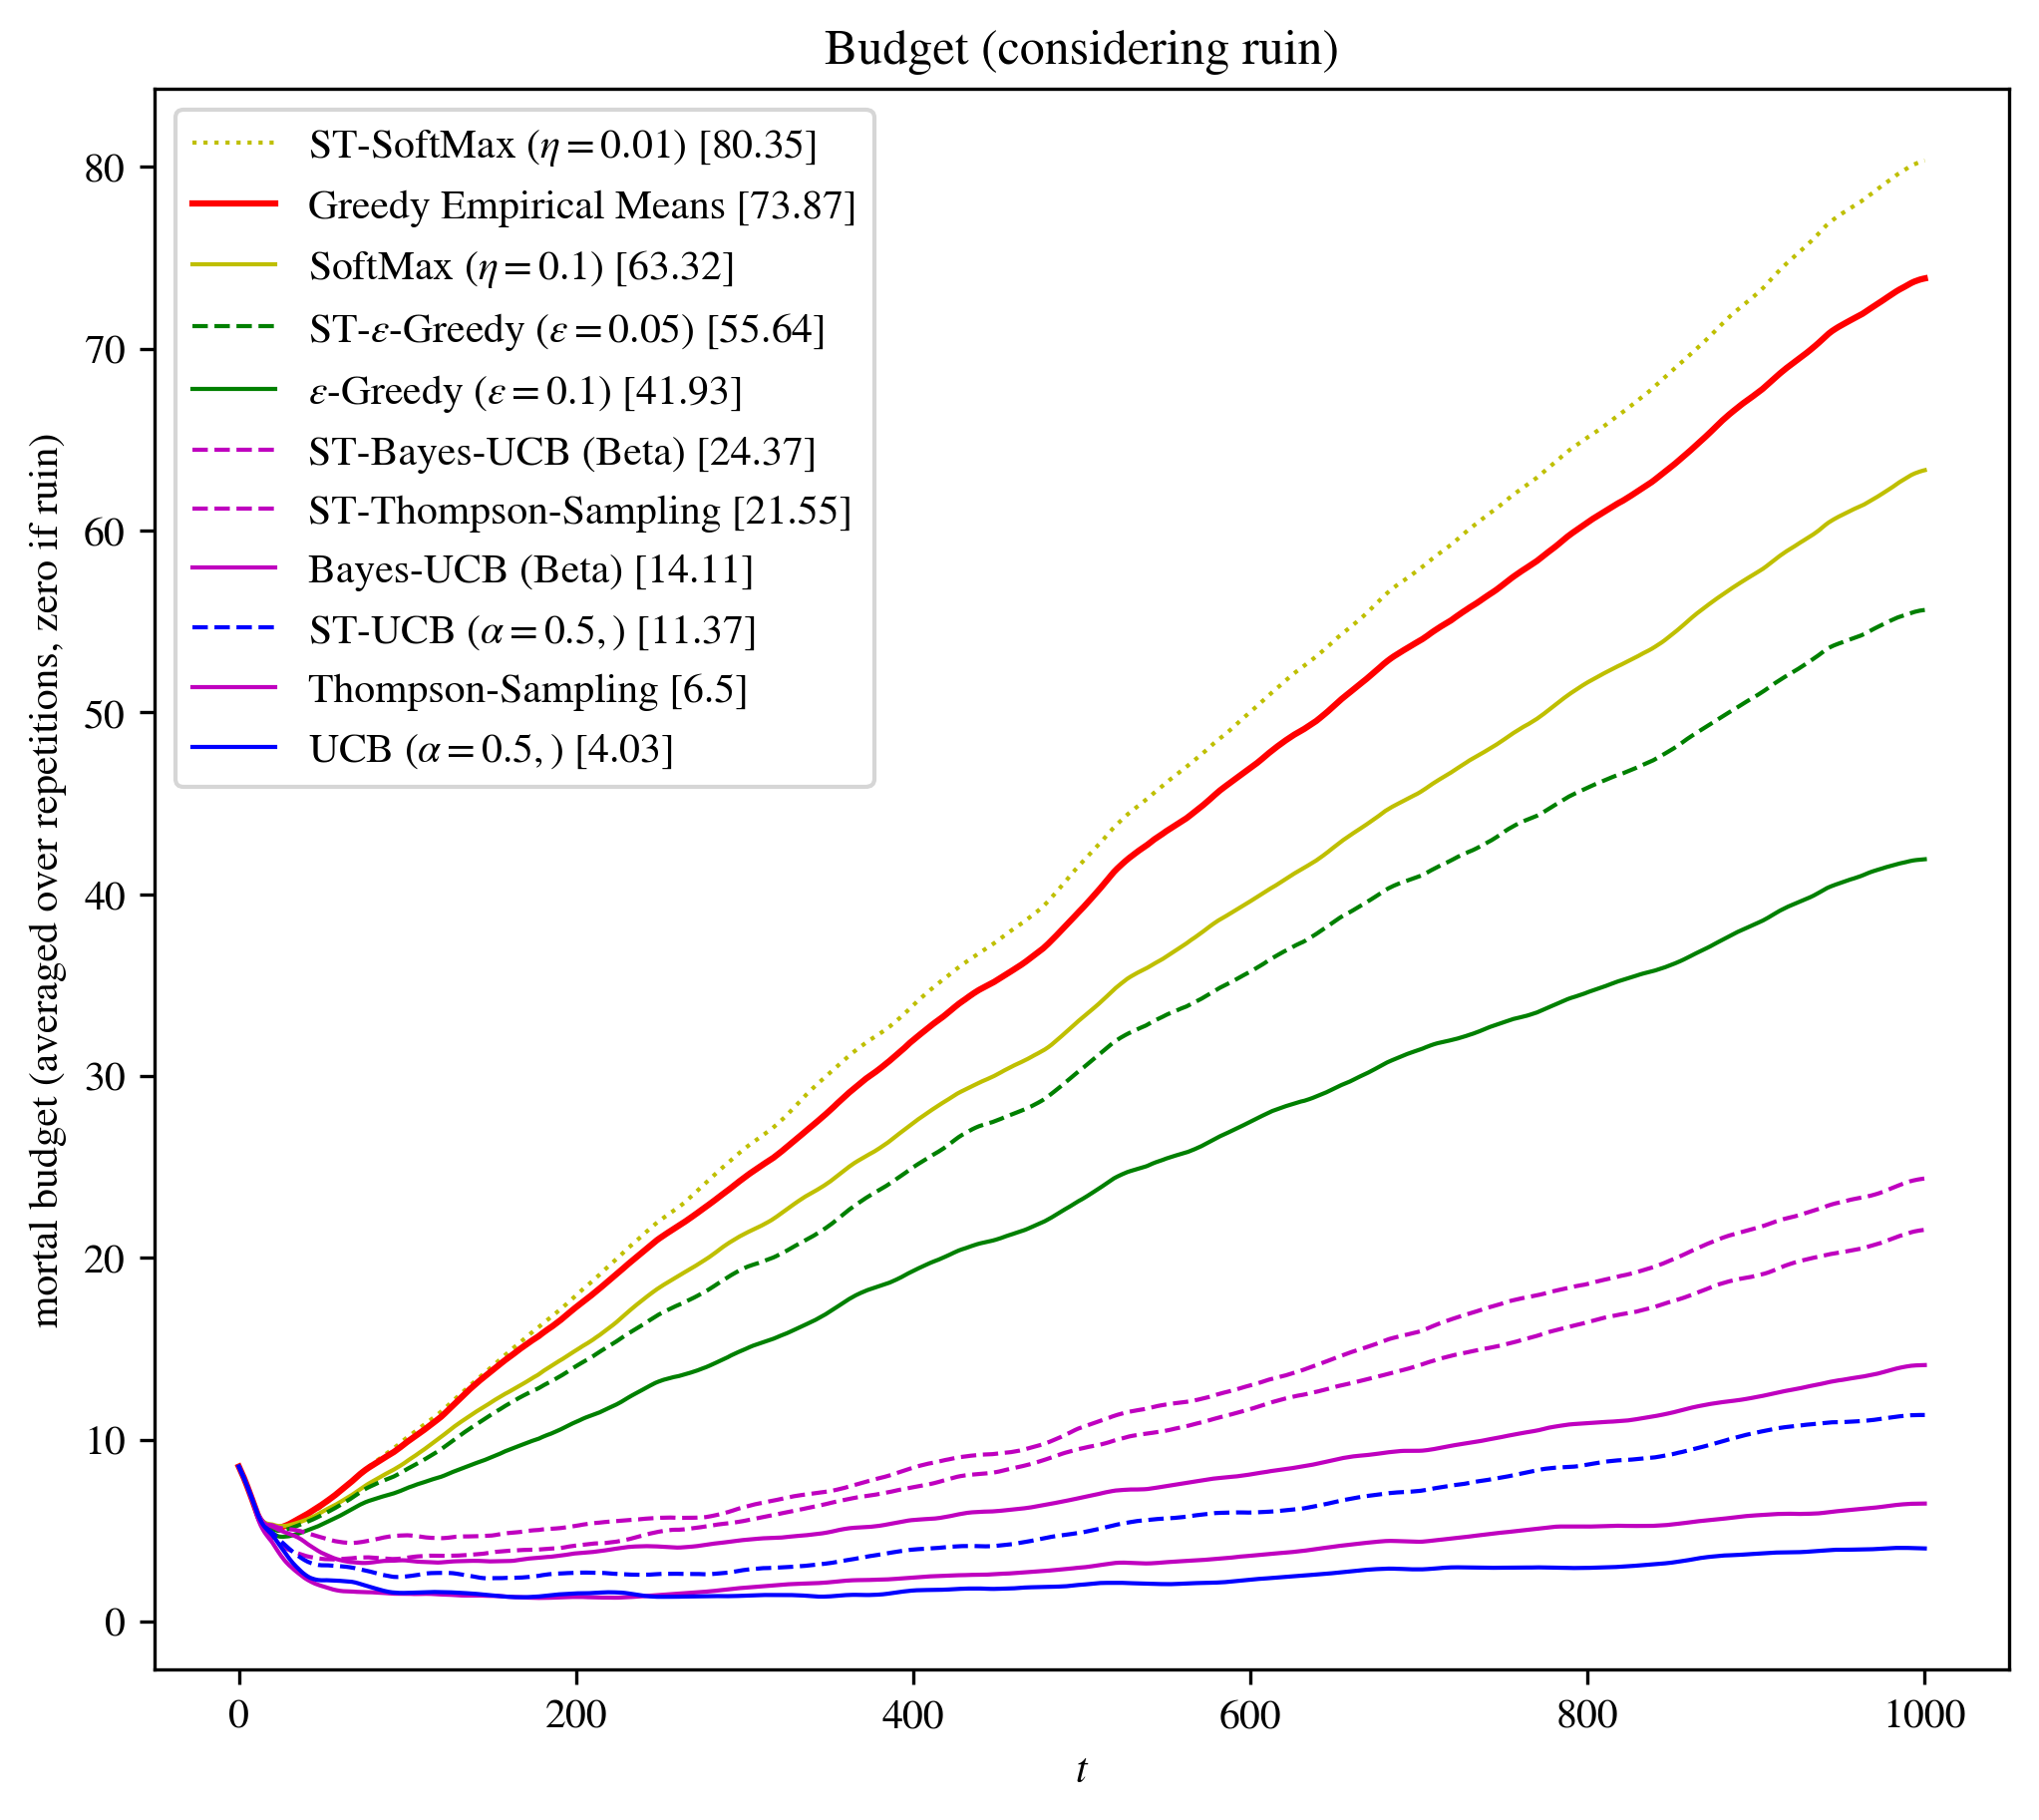

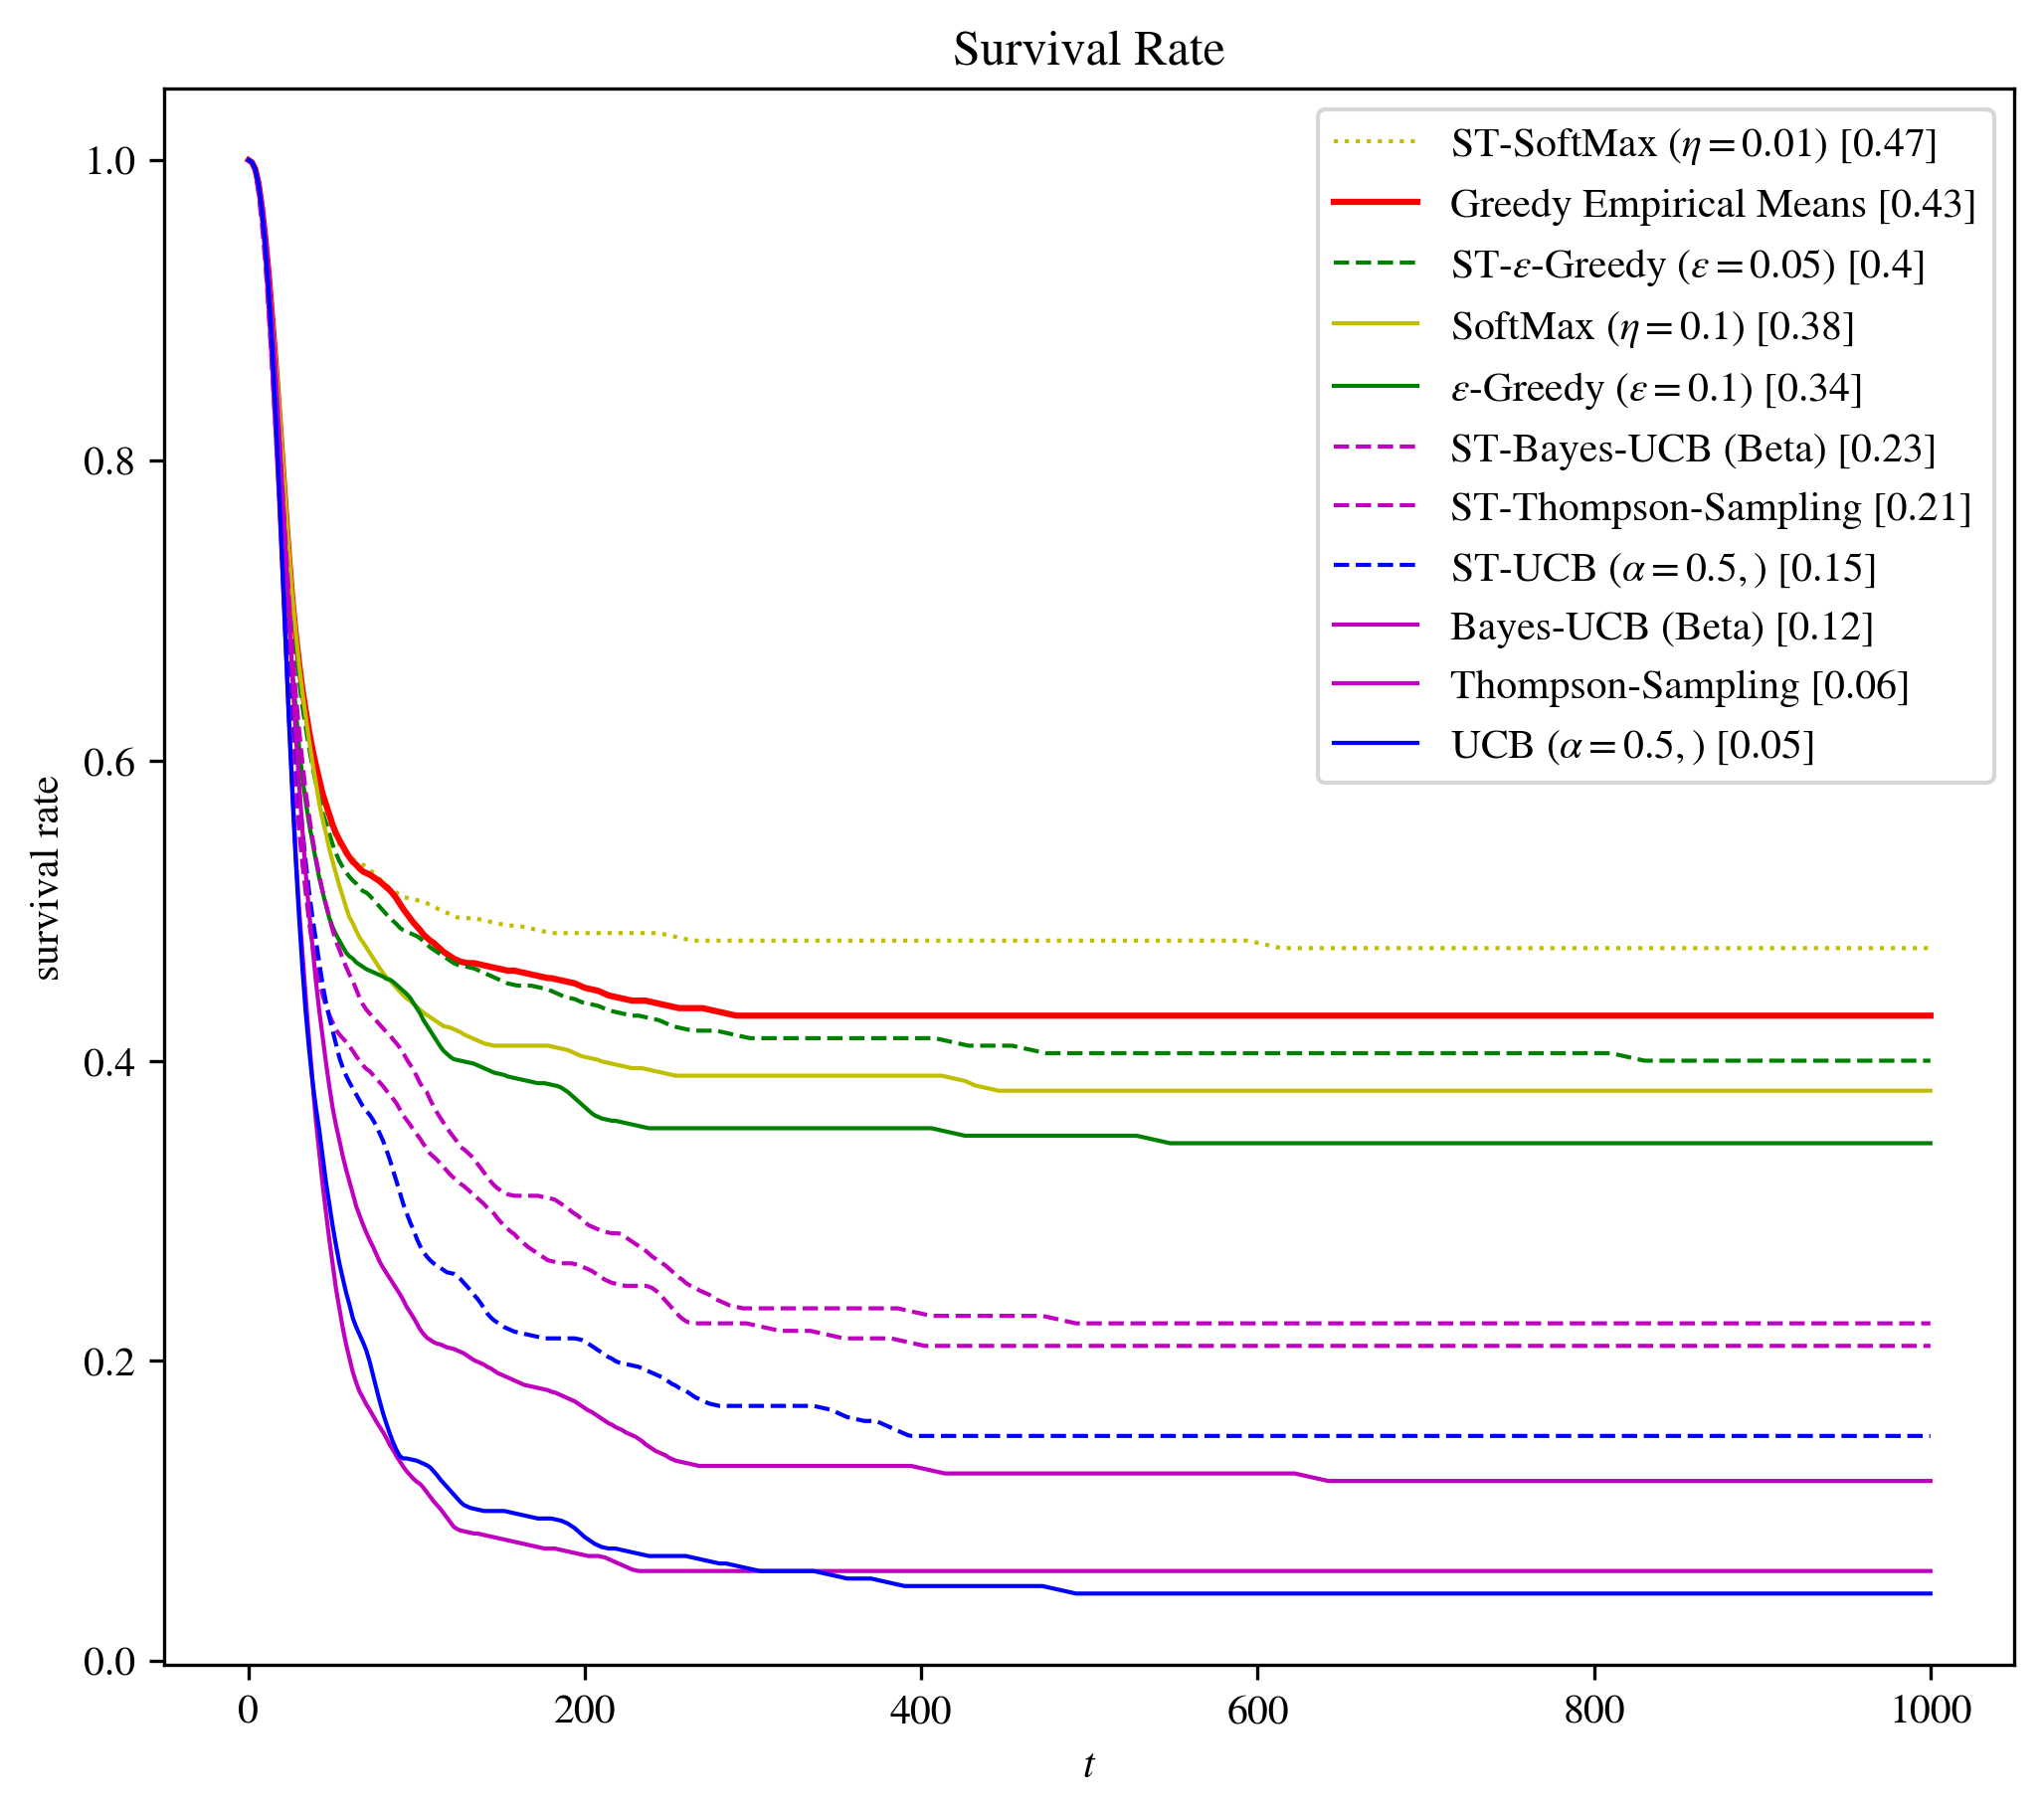

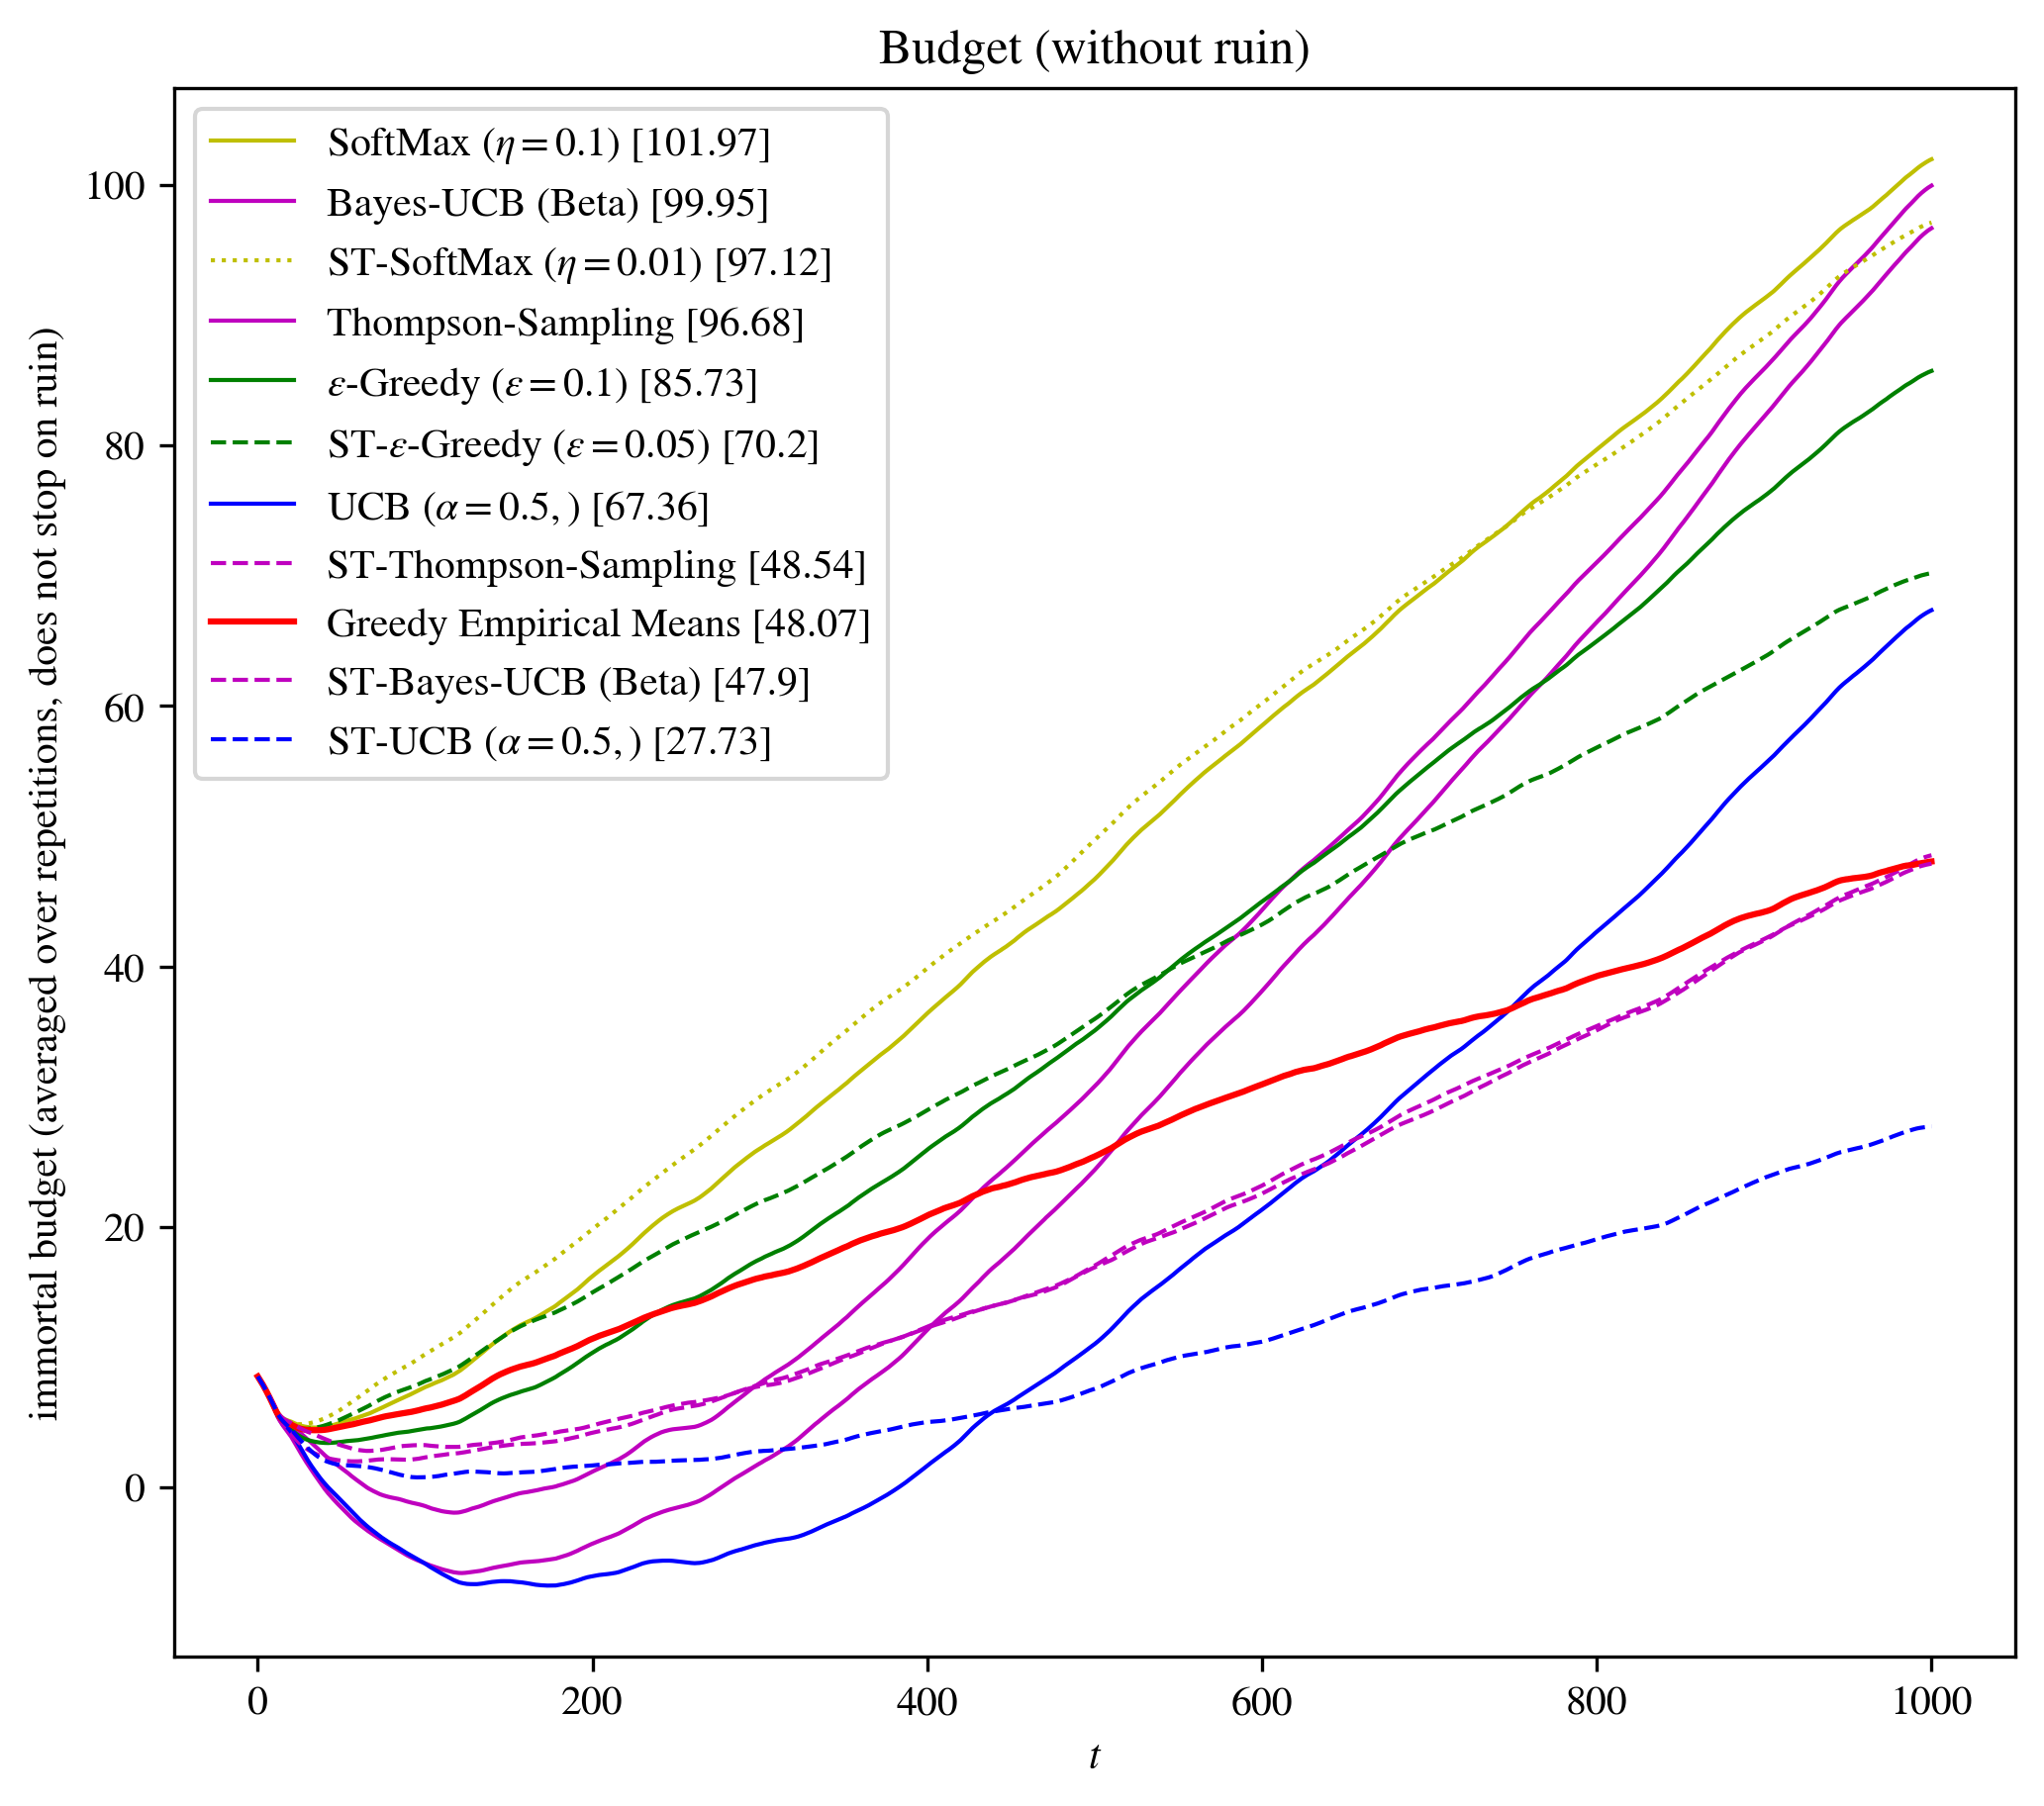

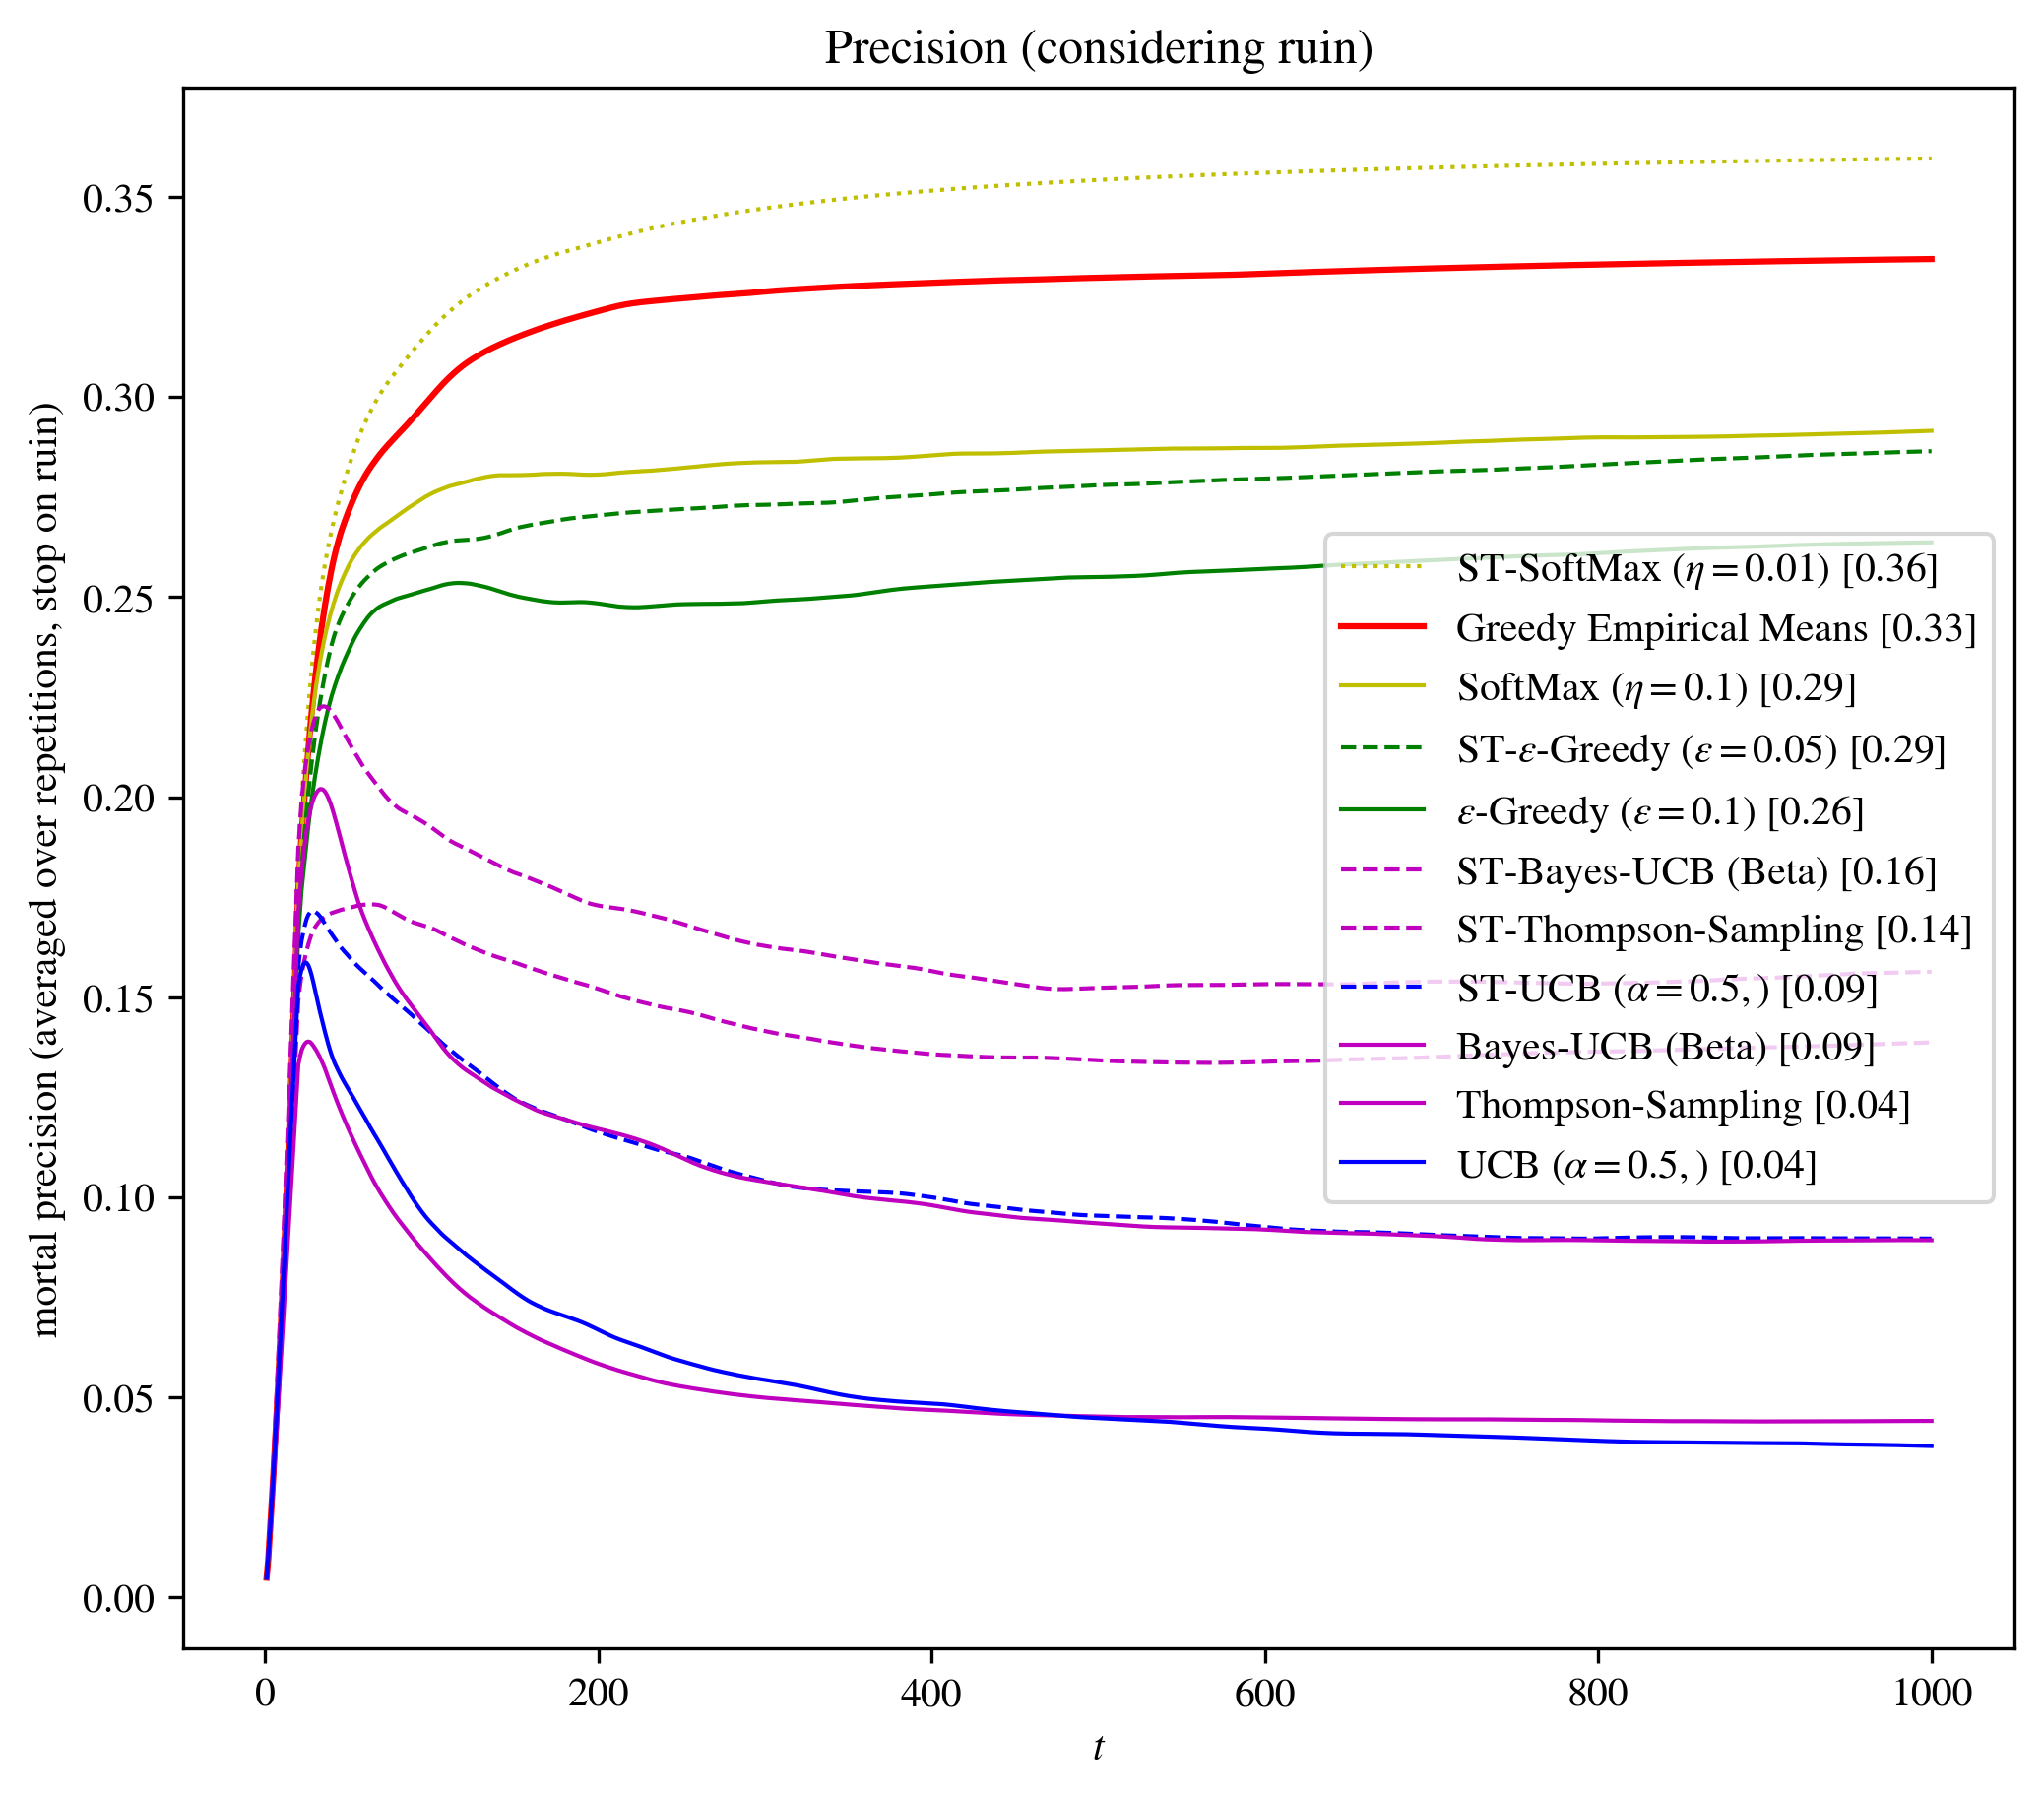

In [34]:
algs_idx=[0,3,5,8,12,19,24,27,28,29,30]
figsize=(8,7)
sim6.plot('mortal_budget', algs_idx=algs_idx, smooth_window=smooth_window, figsize=figsize)
sim6.plot('survival', algs_idx=algs_idx, smooth_window=smooth_window, figsize=figsize)
sim6.plot('immortal_budget', algs_idx=algs_idx, smooth_window=smooth_window, figsize=figsize)
sim6.plot('mortal_precision', algs_idx=algs_idx, smooth_window=smooth_window, figsize=figsize)